<a href="https://colab.research.google.com/github/eeuunnjjiii/kagglestudy/blob/main/Kaggle%20survey/%5B1st_kernel%5D_Novice_to_Grandmaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고 : Novice to Grandmaster(https://www.kaggle.com/ash316/novice-to-grandmaster)

# 캐글 데이터 연동

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eunjijeong","key":"29fdf1c9b4bee7ef56c5520fc84d41dc"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kaggle/kaggle-survey-2017
!unzip kaggle-survey-2017.zip

 28% 1.00M/3.52M [00:00<00:00, 6.88MB/s]
100% 3.52M/3.52M [00:00<00:00, 17.2MB/s]
Archive:  kaggle-survey-2017.zip
  inflating: RespondentTypeREADME.txt  
  inflating: conversionRates.csv     
  inflating: freeformResponses.csv   
  inflating: multipleChoiceResponses.csv  
  inflating: schema.csv              


- 설문조사 데이터로, 가짜이거나 거짓된 응답이 많을 수 있음에 유의 > 아웃라이어 주의!

#1. Introduction

In [3]:
# 트리맵 시각화 라이브러리 설치
!pip install squarify

In [4]:
# 이미지 불러오는 라이브러리 설치
!pip install imageio

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import base64
import io
from imageio import imread
import codecs
from IPython.display import HTML
from matplotlib_venn import venn2
from subprocess import check_output
#print(check_output(['ls', '../input']).decode('utf8'))

In [6]:
response = pd.read_csv('multipleChoiceResponses.csv', encoding = 'ISO-8859-1')

In [7]:
response.head()

GenderSelect  ... JobFactorPublishingOpportunity
0  Non-binary, genderqueer, or gender non-conforming  ...                            NaN
1                                             Female  ...                            NaN
2                                               Male  ...                 Very Important
3                                               Male  ...                            NaN
4                                               Male  ...                            NaN

[5 rows x 228 columns]

## Some Basic Analysis

In [8]:
print('The Total number of respondents:', response.shape[0])
print('Total number of Countries with respondents:', response['Country'].nunique())
print('Country with highest respondents:', response['Country'].value_counts().index[0], 'with', response['Country'].value_counts().values[0], 'respondents')
print('Youngest respondent:', response['Age'].min(), 'and Oldest respondent:', response['Age'].max())

The Total number of respondents: 16716
Total number of Countries with respondents: 52
Country with highest respondents: United States with 4197 respondents
Youngest respondent: 0.0 and Oldest respondent: 100.0


- 가장 어린 응답자는 0살에 가장 나이 많은 응답자는 100살.. > 가짜 응답일듯

## Gender Split

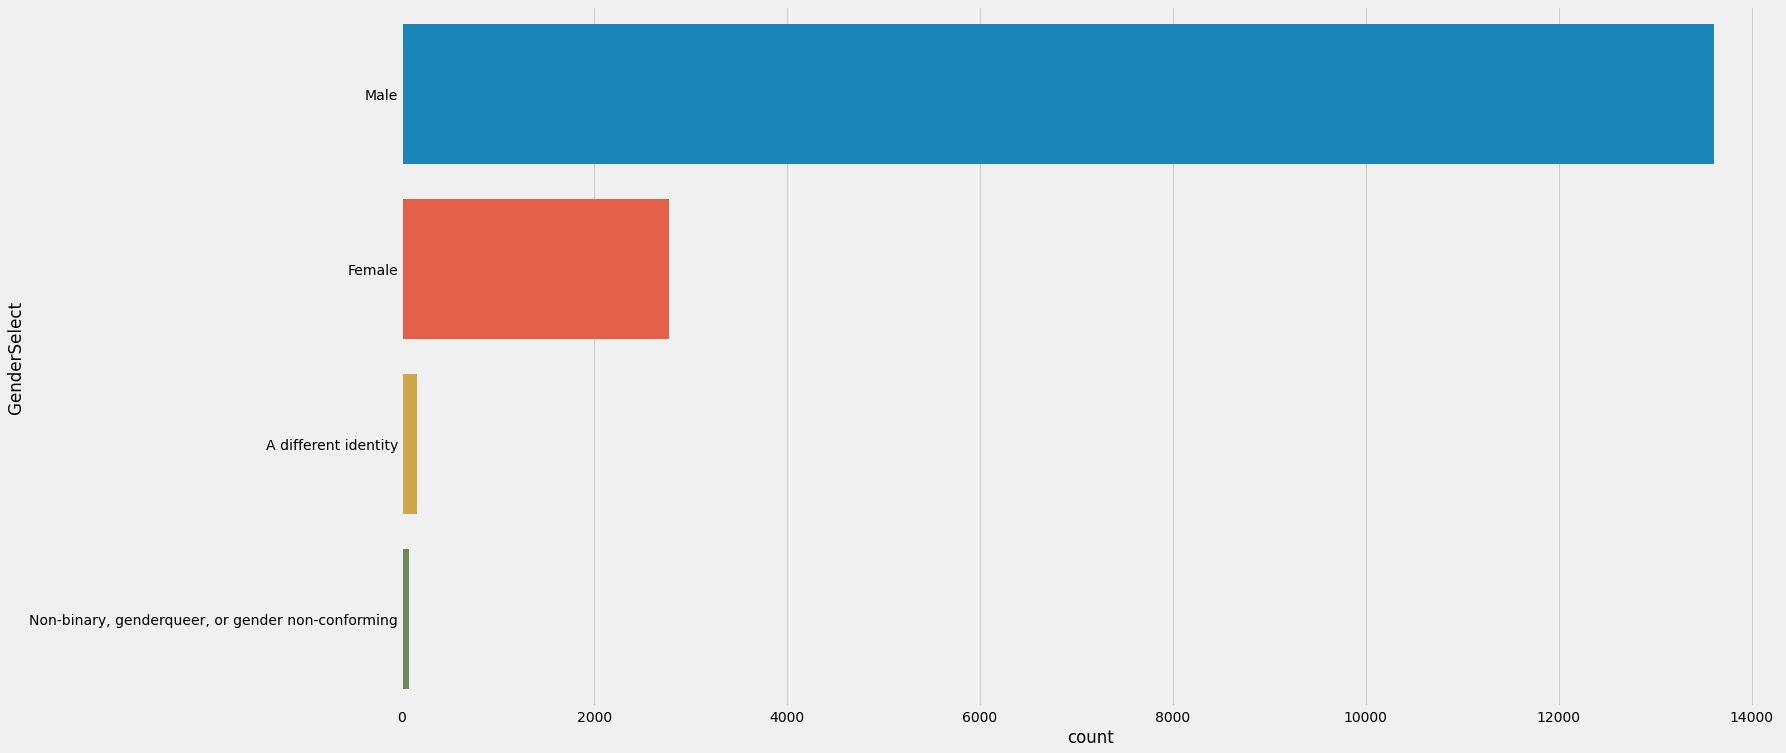

In [9]:
plt.subplots(figsize=(22, 12))
sns.countplot(y=response['GenderSelect'], order=response['GenderSelect'].value_counts().index)
plt.show()

- 여성 응답자에 비해 남성 응답자가 많음

## Respondents By country

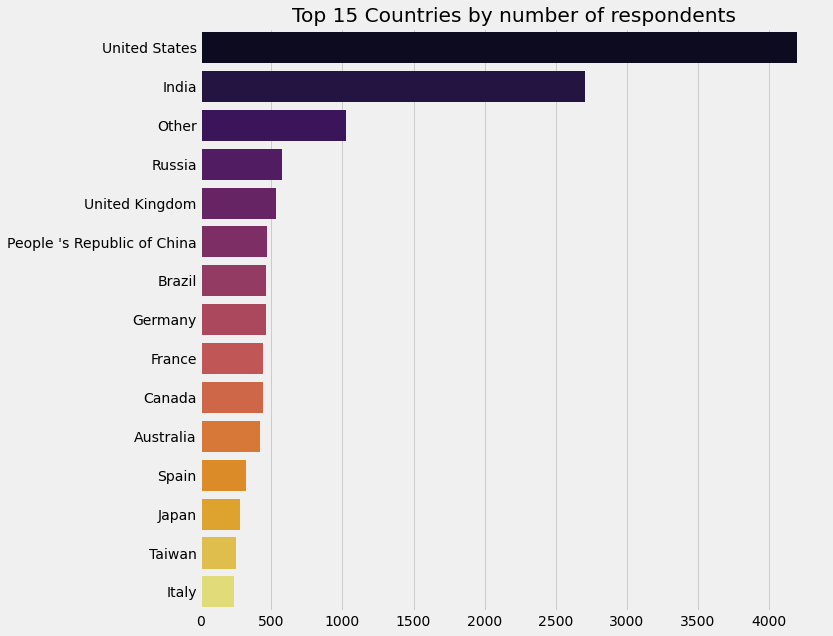

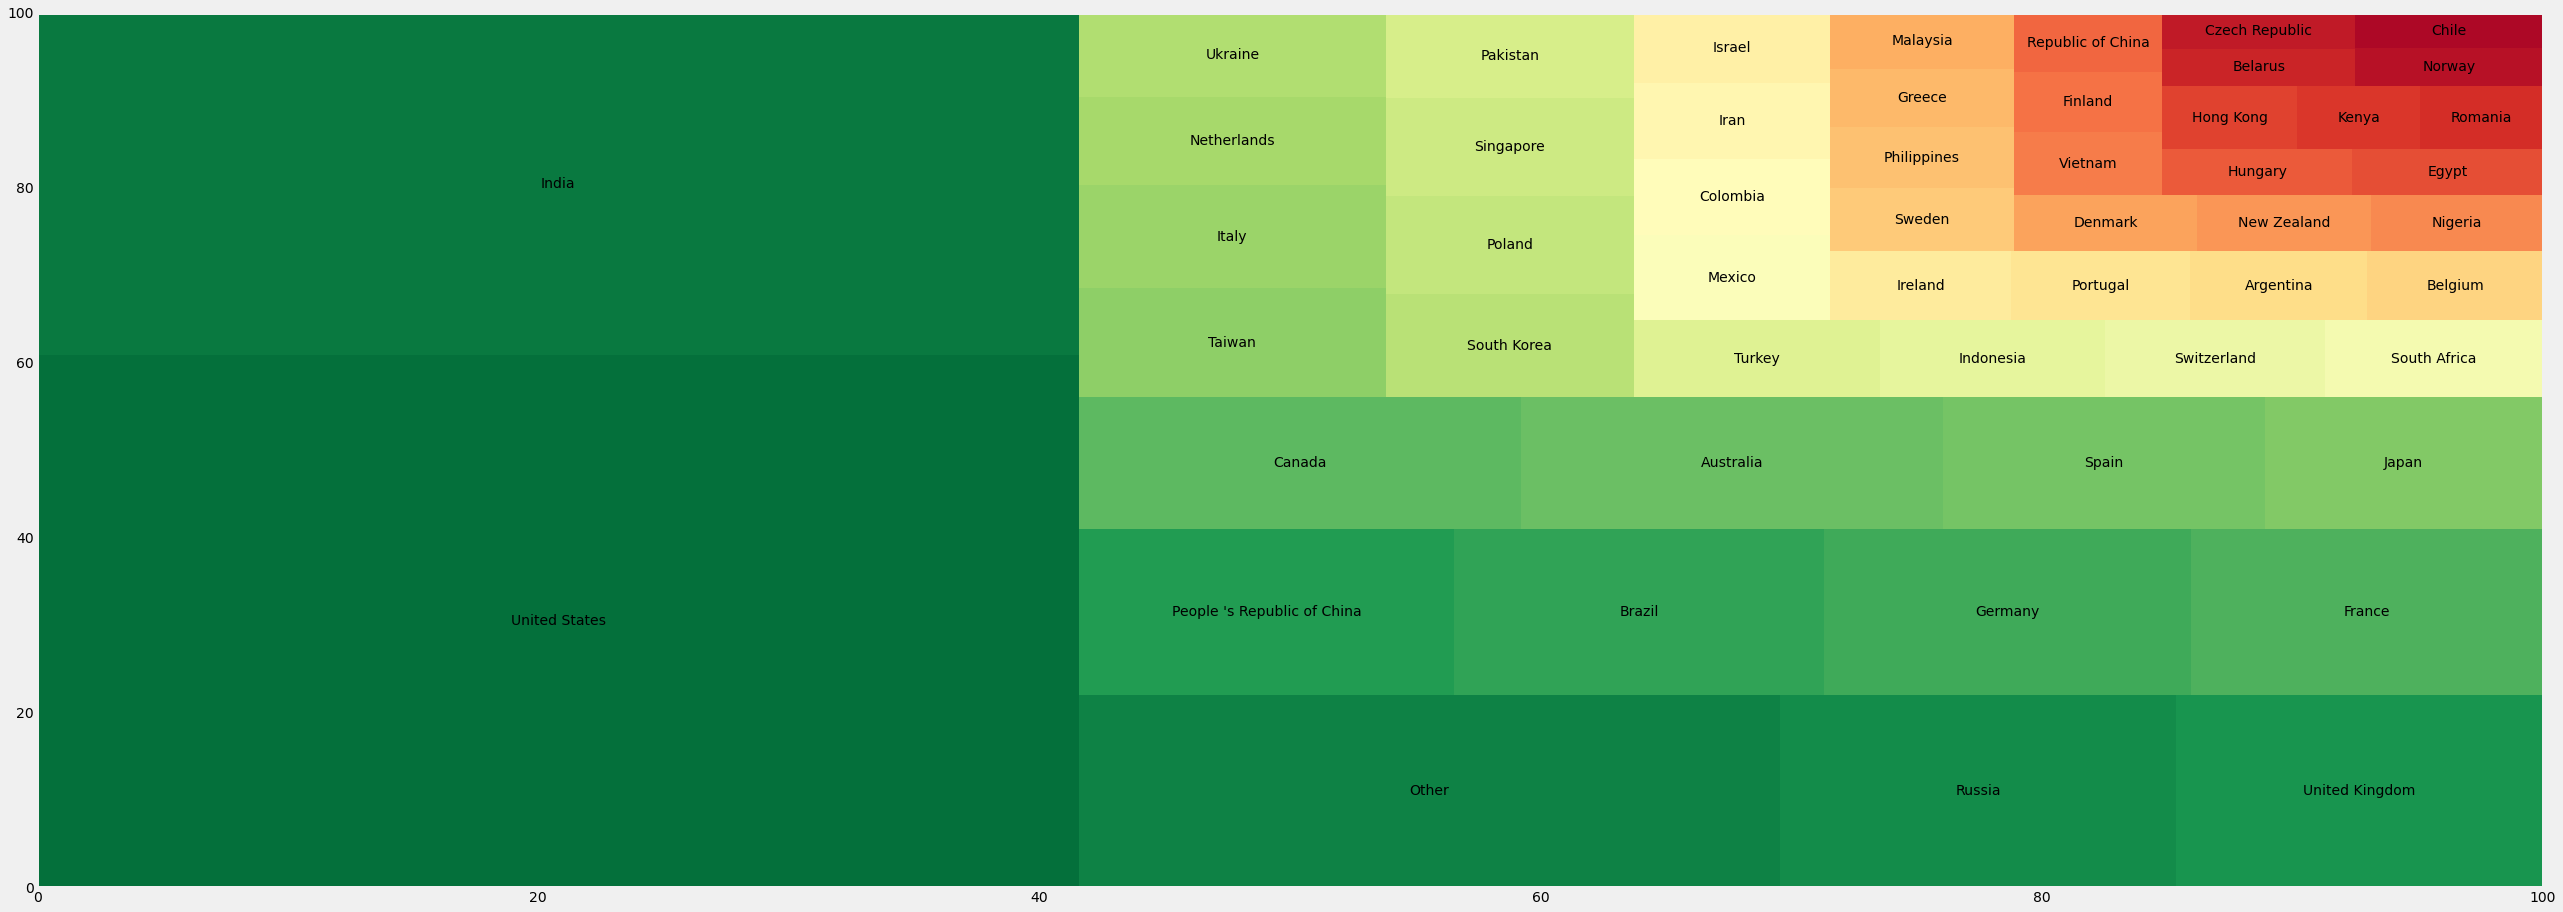

In [10]:
resp_coun = response['Country'].value_counts()[:15].to_frame()
sns.barplot(resp_coun['Country'], resp_coun.index, palette='inferno')
plt.title('Top 15 Countries by number of respondents')
plt.xlabel('')
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

tree = response['Country'].value_counts().to_frame()
squarify.plot(sizes=tree['Country'].values, label=tree.index, color=sns.color_palette('RdYlGn_r', 52))
plt.rcParams.update({'font.size':20})
fig = plt.gcf()
fig.set_size_inches(40, 15)
plt.show()

- 미국과 인도가 전체 응답자의 1/3
- 칠레는 응답자 수가 가장 적음
- 그렇다고 캐글 유저의 대부분은 미국인과 인도인이라고 말할 수는 없음 > 응답자 자체가 적기 때문

##Compensation

In [11]:
response['CompensationAmount'][:4]

0        NaN
1        NaN
2        NaN
3    250,000
Name: CompensationAmount, dtype: object

In [12]:
response['CompensationAmount'] = response['CompensationAmount'].str.replace(',','')
response['CompensationAmount'] = response['CompensationAmount'].str.replace('-','')
rates = pd.read_csv('conversionRates.csv', index_col=0)
salary = response[['CompensationAmount', 'CompensationCurrency', 'GenderSelect', 'Country', 'CurrentJobTitleSelect']].dropna()
salary = salary.merge(rates, left_on='CompensationCurrency', right_on='originCountry', how='left') ## 내용 같은 컬럼명 지정
salary['Salary'] = pd.to_numeric(salary['CompensationAmount']) * salary['exchangeRate']
print('Maximum Salary is USD $', salary['Salary'].dropna().astype(int).max())
print('Minimum Salary is USD $', salary['Salary'].dropna().astype(int).min())
print('Median Salary is USD $', salary['Salary'].dropna().astype(int).median())

Maximum Salary is USD $ 28297400000
Minimum Salary is USD $ 0
Median Salary is USD $ 53812.0


- 말도 안되는 최고 급여
- 급여가 0인 경우는 학생일 듯
- 중앙값을 보니 Data Scientist가 충분히 좋은 보상을 받는 직업인 것을 알려줌

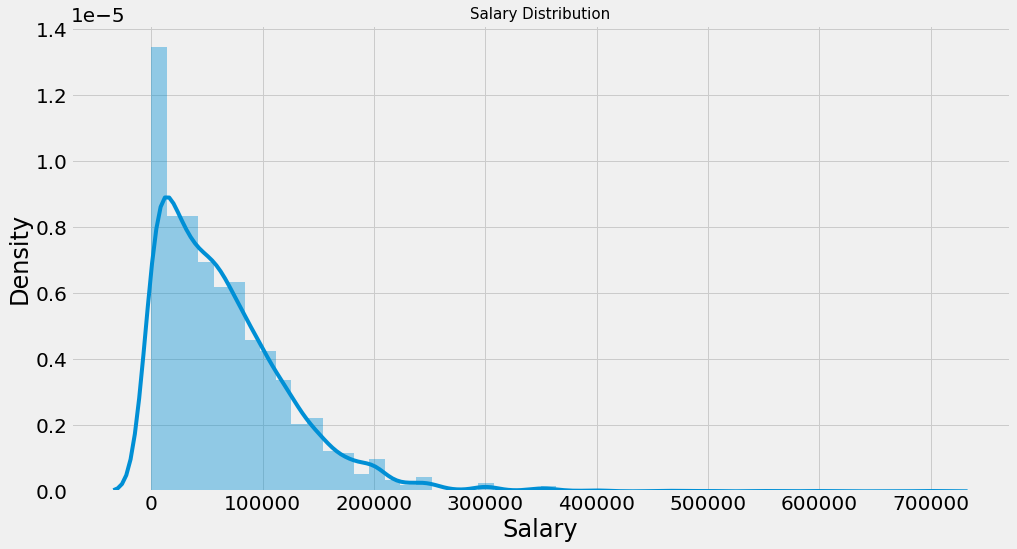

In [13]:
plt.subplots(figsize=(15, 8))
salary = salary[salary['Salary'] < 1000000]
sns.distplot(salary['Salary'])
plt.title('Salary Distribution', size=15)
plt.show()

## Compensation by Country

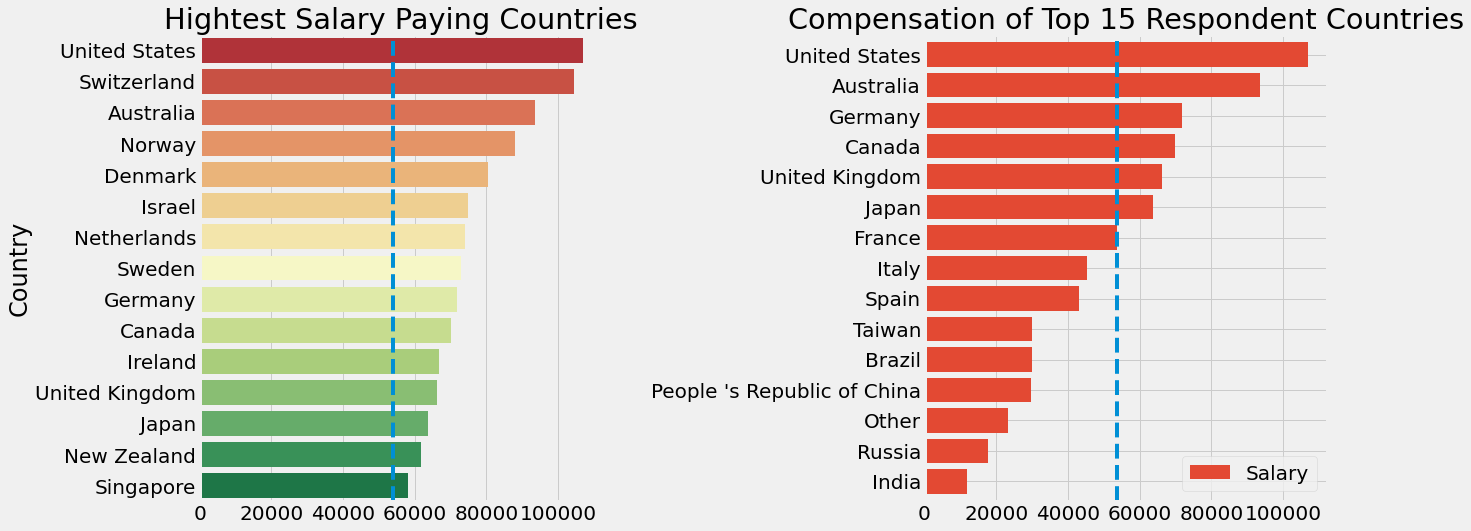

In [14]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
sal_coun = salary.groupby('Country')['Salary'].median().sort_values(ascending=False)[:15].to_frame()
sns.barplot('Salary', sal_coun.index, data=sal_coun, palette='RdYlGn', ax=ax[0])
ax[0].axvline(salary['Salary'].median(), linestyle='dashed')
ax[0].set_title('Hightest Salary Paying Countries')
ax[0].set_xlabel('')
max_coun = salary.groupby('Country')['Salary'].median().to_frame()
max_coun = max_coun[max_coun.index.isin(resp_coun.index)]
max_coun.sort_values(by='Salary', ascending=True).plot.barh(width=0.8, ax=ax[1], color=sns.color_palette('RdYlGn'))
ax[1].axvline(salary['Salary'].median(), linestyle='dashed')
ax[1].set_title('Compensation of Top 15 Respondent Countries')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
plt.subplots_adjust(wspace=0.8)
plt.show()

- 왼쪽 그래프는 급여의 중앙값을 기준으로 Top 15개 국가를 나타냄 > 이 국가들은 전체 데이터셋의 급여 중앙값보다 더 많은 급여 제공
- 오른쪽 그래프는 응답자 기준 Top 15개 국가의 중앙값을 나타냄 > 인도는 응답자 수가 두번째로 높았으나,급여는 매우 낮음

## Salary By Gender

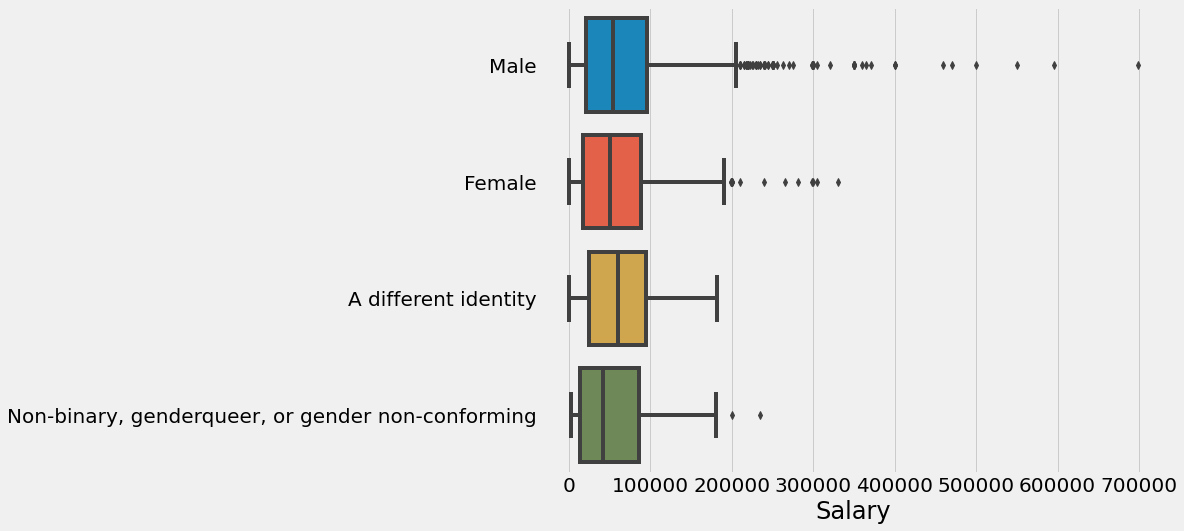

In [15]:
plt.subplots(figsize=(10, 8))
sns.boxplot(y='GenderSelect', x='Salary', data=salary)
plt.ylabel('')
plt.show()

- 남성의 급여가 다른 성별보다 더 많은 것으로 보임

## Age

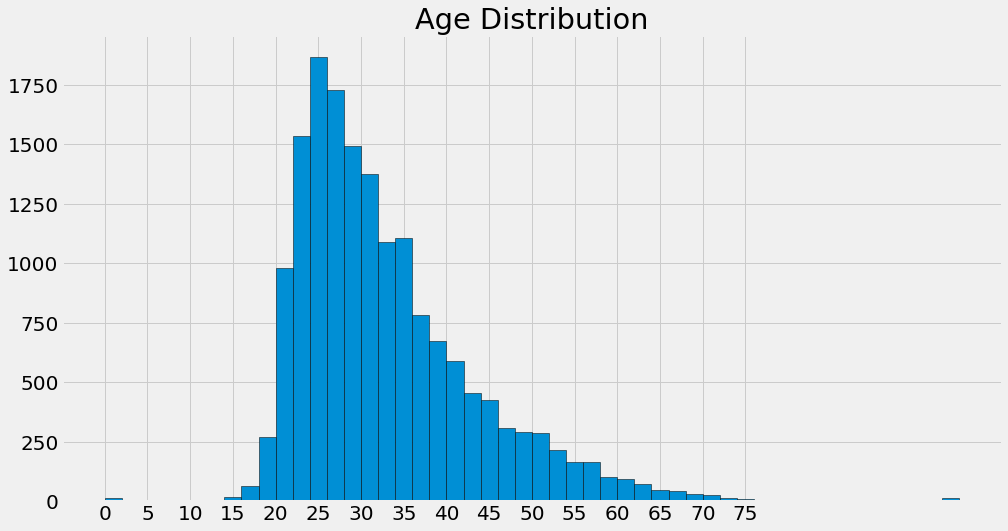

In [16]:
plt.subplots(figsize=(15, 8))
response['Age'].hist(bins=50, edgecolor='black')
plt.xticks(list(range(0, 80, 5)))
plt.title('Age Distribution')
plt.show()

- 25-35세 응답자가 가장 많음

## Profession & Major

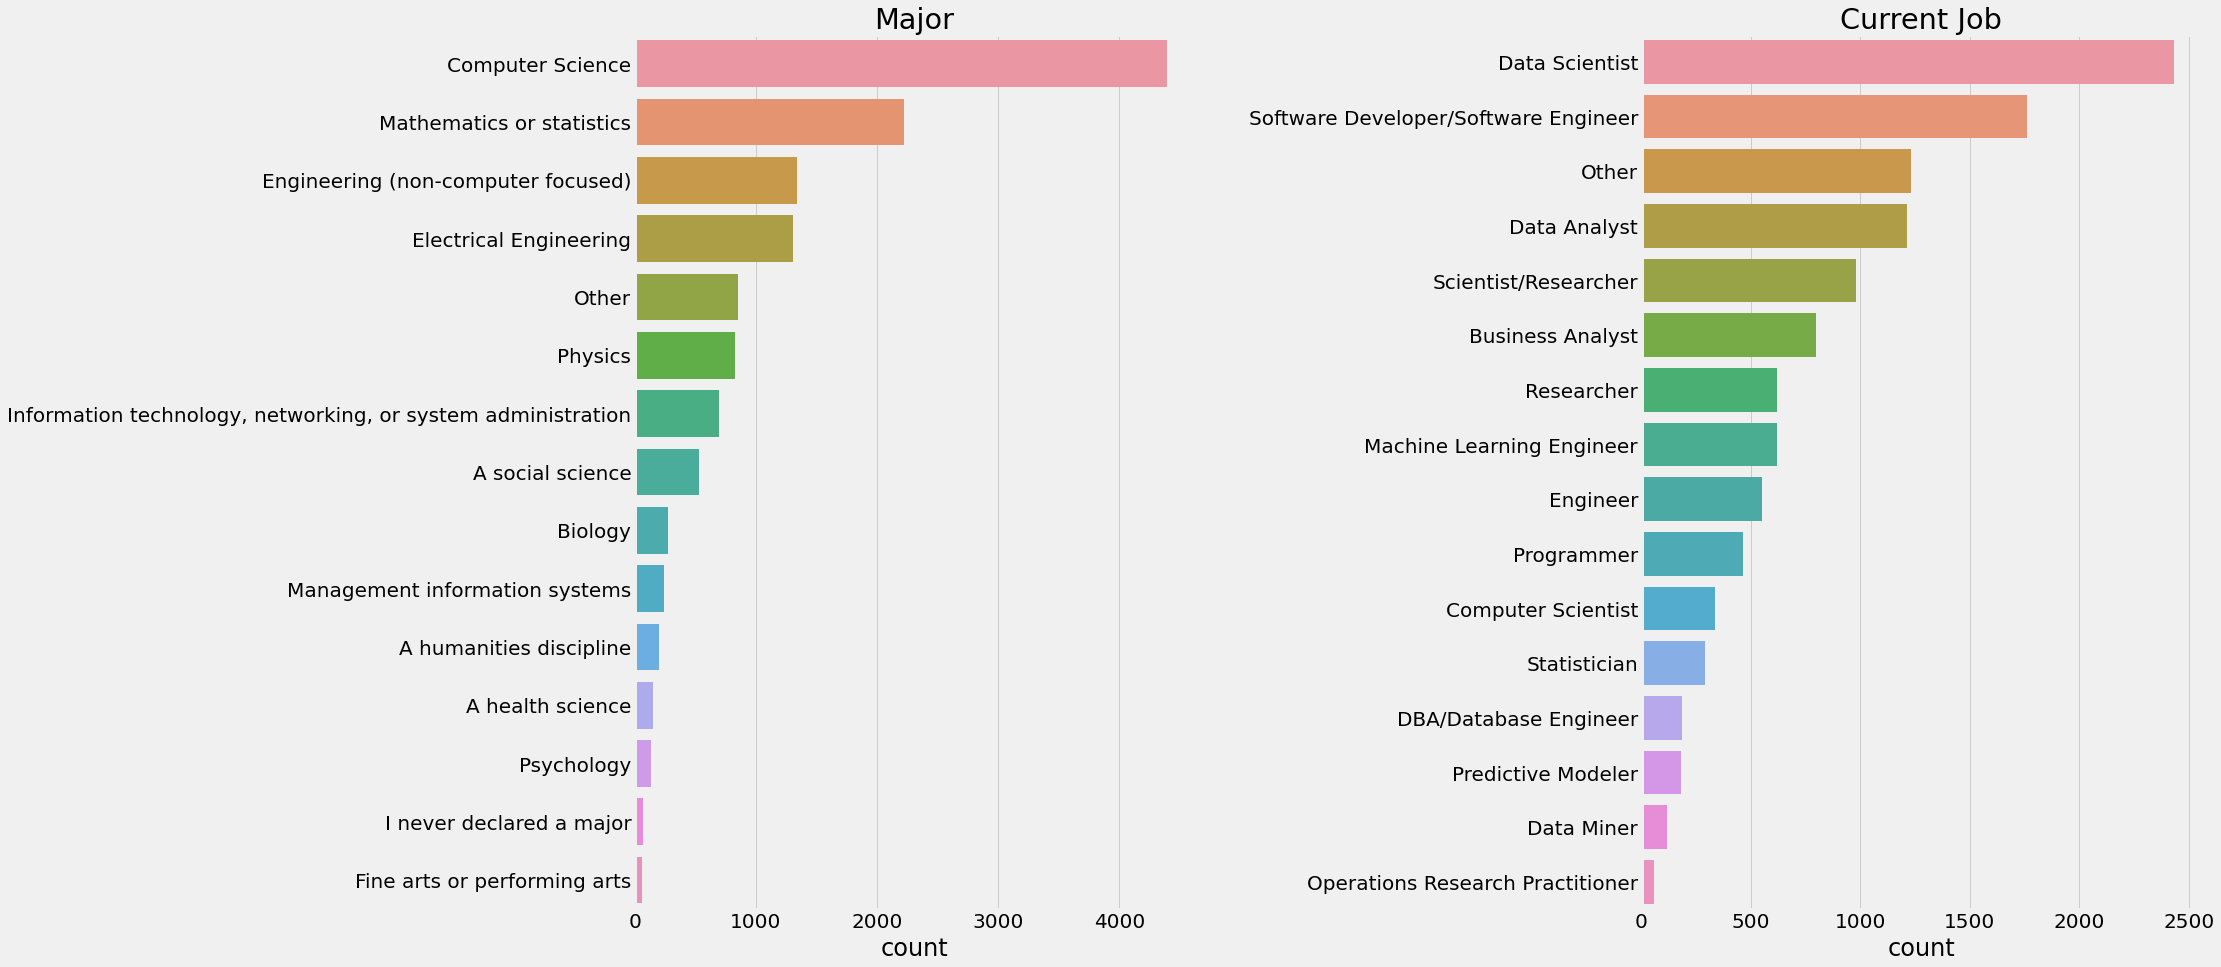

In [17]:
f, ax = plt.subplots(1, 2, figsize=(25, 15))
sns.countplot(y=response['MajorSelect'], ax=ax[0], order=response['MajorSelect'].value_counts().index)
ax[0].set_title('Major')
ax[0].set_ylabel('')

sns.countplot(y=response['CurrentJobTitleSelect'], ax=ax[1], order=response['CurrentJobTitleSelect'].value_counts().index)
ax[1].set_title('Current Job')
ax[1].set_ylabel('')
plt.subplots_adjust(wspace=0.8)
plt.show()

- 왼쪽 그래프에서 전공이 다양함 > Data Science와 ML은 거의 모든 산업에서 사용됨
- 오른쪽 그래프에서 현재 직업이 DataScientist라고 대답한 비율이 가장 높음 > 진실인지 추후 확인

## Compensation By Job Title

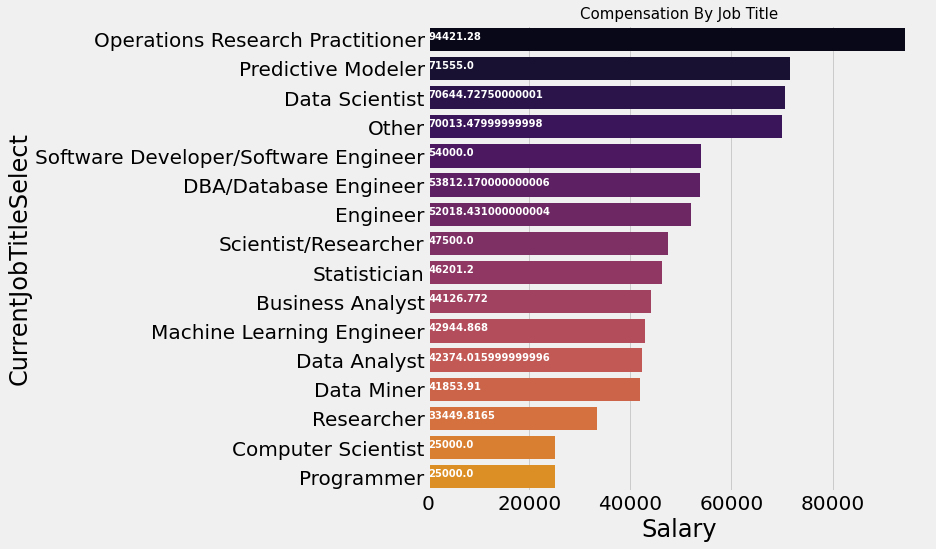

In [18]:
sal_job = salary.groupby('CurrentJobTitleSelect')['Salary'].median().to_frame().sort_values(by='Salary', ascending=False)
ax = sns.barplot(sal_job.Salary, sal_job.index, palette=sns.color_palette('inferno', 20))
plt.title('Compensation By Job Title', size=15)
for i, v in enumerate(sal_job.Salary):
  ax.text(.5, i, v, fontsize=10, color='white', weight='bold')
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.show()

- Operations Research Practitioner 직업의 급여 중앙값이 가장 높고, 그 뒤로 Predictive Modeler, Data Scientist이며 Computer Scientist와 Programmer의 급여가 가장 낮음

## Machine Learning

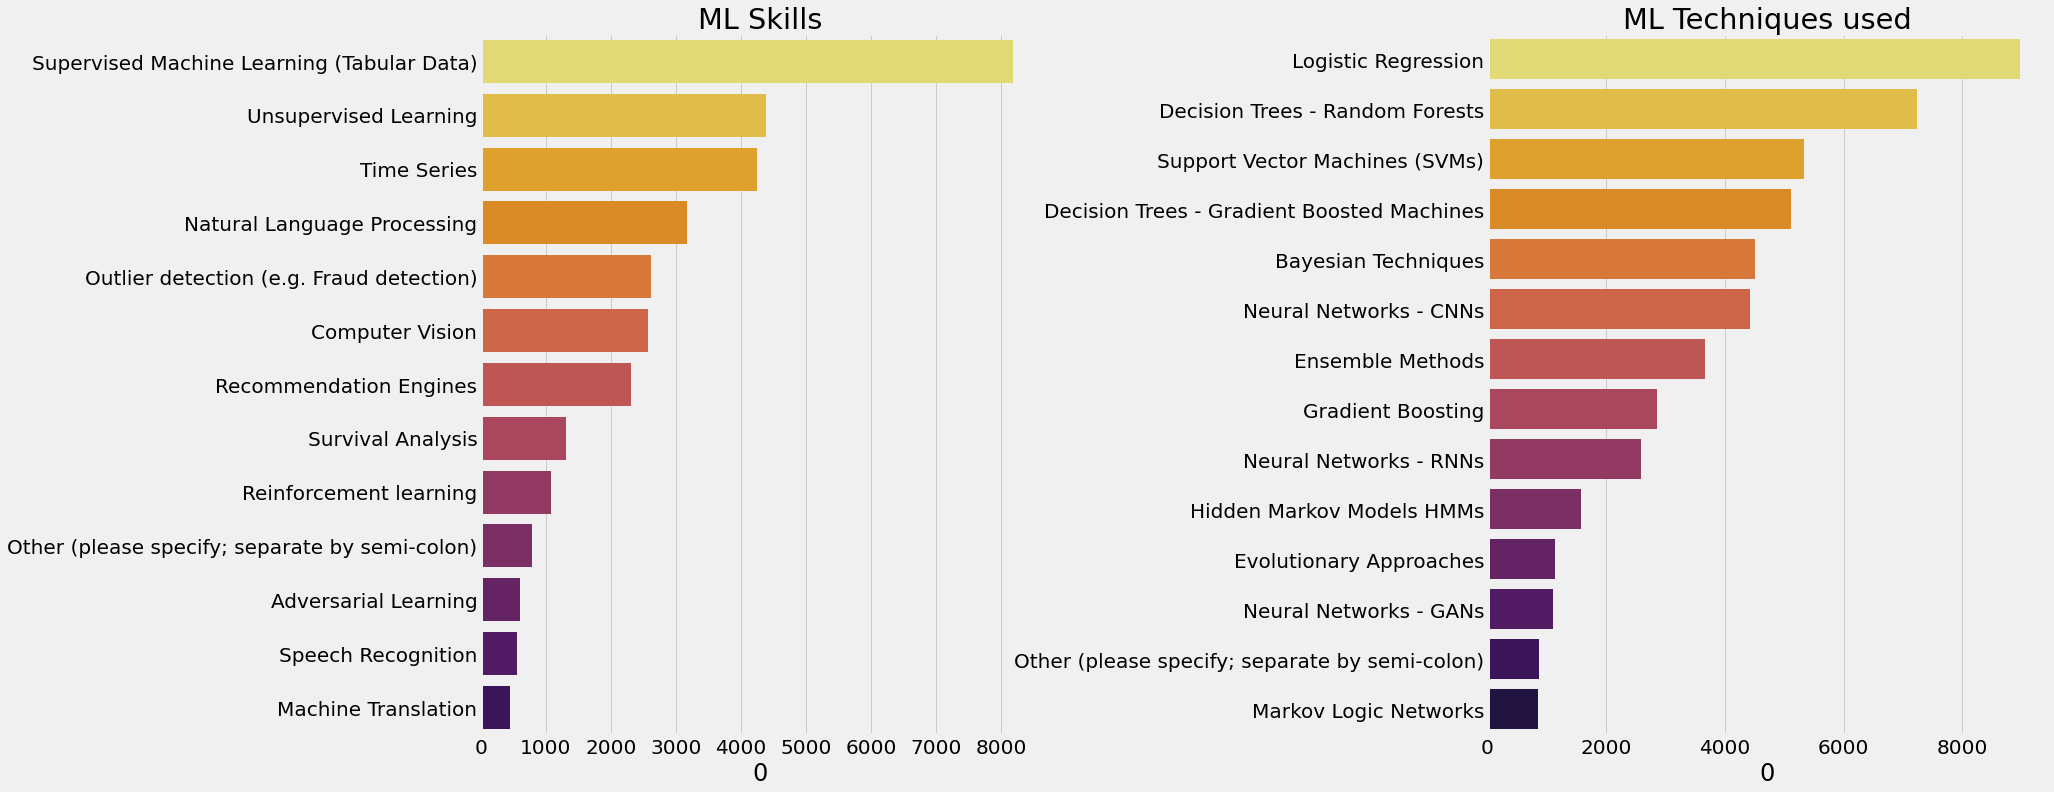

In [19]:
f, ax = plt.subplots(1, 2, figsize=(25, 12))
skills = response['MLSkillsSelect'].str.split(',')
skills_set=[]
for i in skills.dropna():
  skills_set.extend(i)
plt1 = pd.Series(skills_set).value_counts().sort_values(ascending=False).to_frame()
sns.barplot(plt1[0], plt1.index, ax=ax[0], palette=sns.color_palette('inferno_r', 15))
ax[0].set_title('ML Skills')

tech = response['MLTechniquesSelect'].str.split(',')
techniques = []
for i in tech.dropna():
  techniques.extend(i)
plt1 = pd.Series(techniques).value_counts().sort_values(ascending=False).to_frame()
sns.barplot(plt1[0], plt1.index, ax=ax[1], palette=sns.color_palette('inferno_r', 15))
ax[1].set_title('ML Techniques used')
plt.subplots_adjust(wspace=0.8)
plt.show()

- 응답자 대부분은 지도 학습을 진행중이며, 그중 Logistic Regression이 가장 많이 쓰임

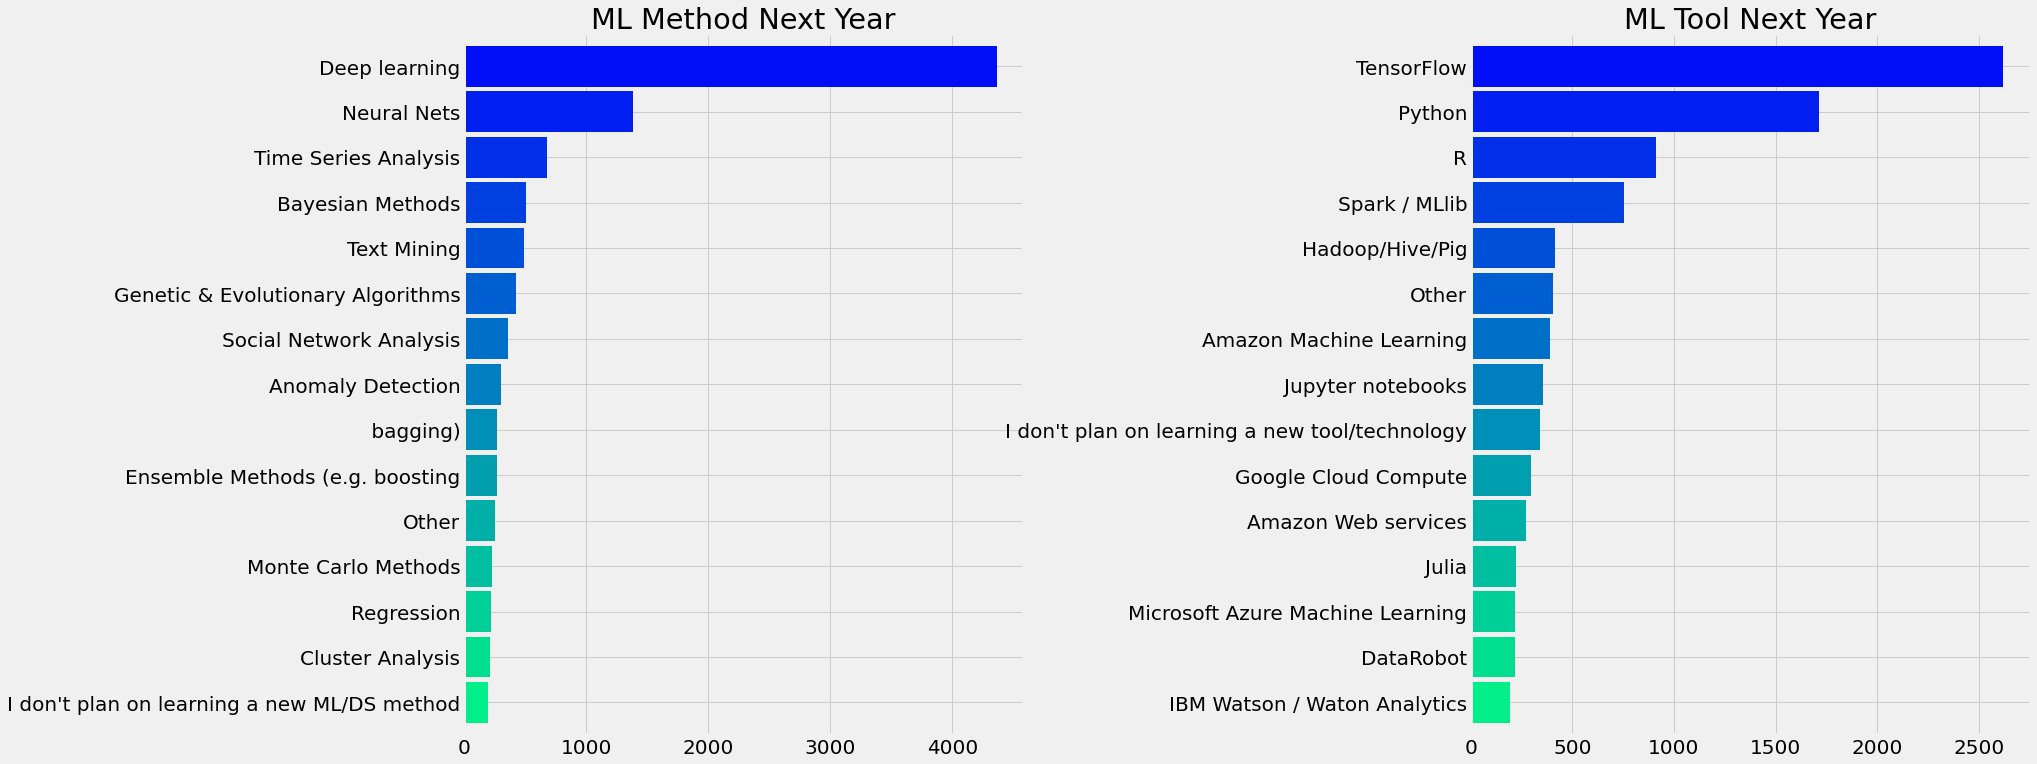

In [20]:
f, ax = plt.subplots(1, 2, figsize=(25, 12))
ml_nxt = response['MLMethodNextYearSelect'].str.split(',')
nxt_year = []
for i in ml_nxt.dropna():
  nxt_year.extend(i)
pd.Series(nxt_year).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9, color=sns.color_palette('winter_r', 15), ax=ax[0])
tool = response['MLToolNextYearSelect'].str.split(',')
tool_nxt = []
for i in tool.dropna():
  tool_nxt.extend(i)
pd.Series(tool_nxt).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9, color=sns.color_palette('winter_r', 15), ax=ax[1])
plt.subplots_adjust(wspace=0.8)
ax[0].set_title('ML Method Next Year')
ax[1].set_title('ML Tool Next Year')
plt.show()

- 내년에 딥러닝 실무자 수가 급증할 듯
- 딥러닝과 신경망, AI는 다음 해에 가장 인기있는 토픽
- 툴은 Python이 R보다 선호되며, Spark, Hadoop과 같은 빅데이터 관련 툴도 상당한 점유율을 차지 할 것

## Best Platforms to learn

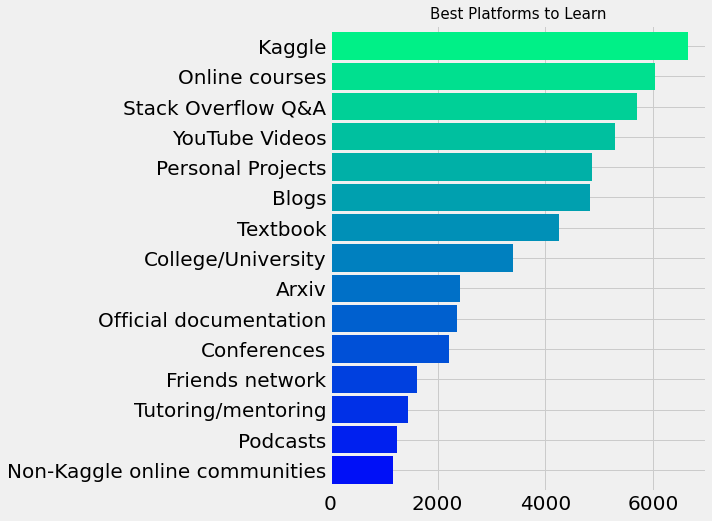

In [21]:
plt.subplots(figsize=(6, 8))
learn = response['LearningPlatformSelect'].str.split(',')
platform = []
for i in learn.dropna():
  platform.extend(i)
pd.Series(platform).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9, color=sns.color_palette('winter', 15))
plt.title('Best Platforms to Learn', size=15)
plt.show()

- 학습에 가장 좋은 플랫폼은 Kaggle, MOOC's와 같은 Online Course 순이며, Textbook이 중앙에 위치

## Hardware Used

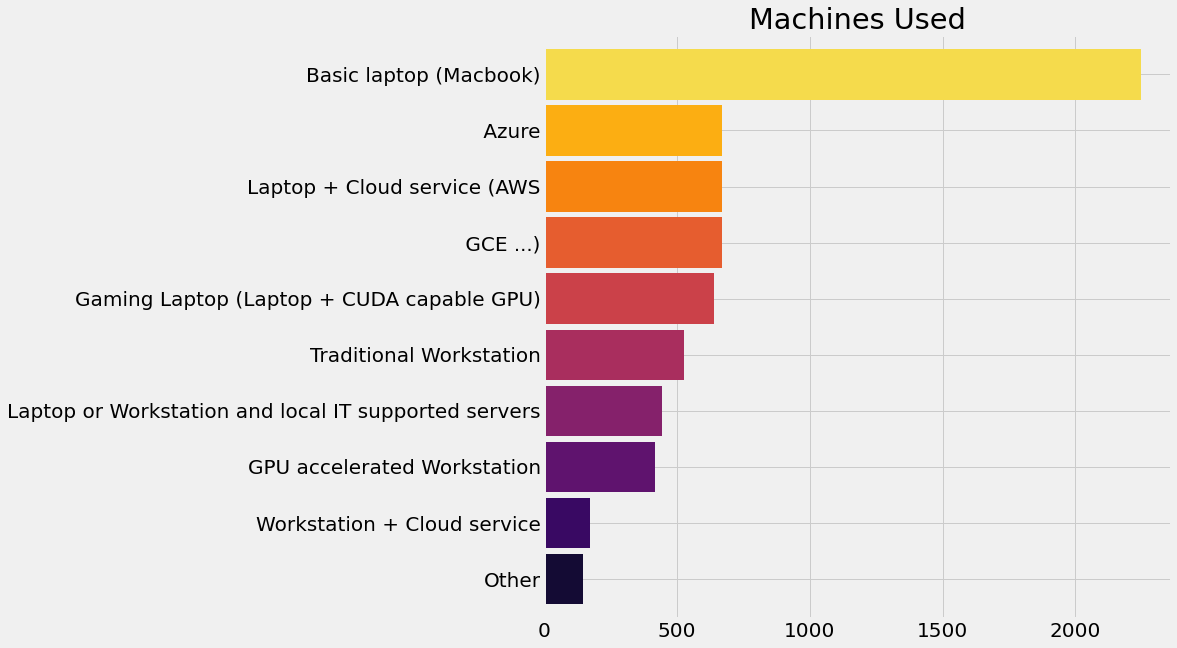

In [22]:
plt.subplots(figsize=(10, 10))
hard = response['HardwarePersonalProjectsSelect'].str.split(',')
hardware = []
for i in hard.dropna():
  hardware.extend(i)
pd.Series(hardware).value_counts().sort_values(ascending=True).plot.barh(width=0.9, color=sns.color_palette('inferno', 10))
plt.title('Machines Used')
plt.show()

- 응답자 대부분이 25세 이하이고 학생일 가능성이 높기 때문에 기본 랩탑이 많이 사용됨

## Where Do I get Datasets From??

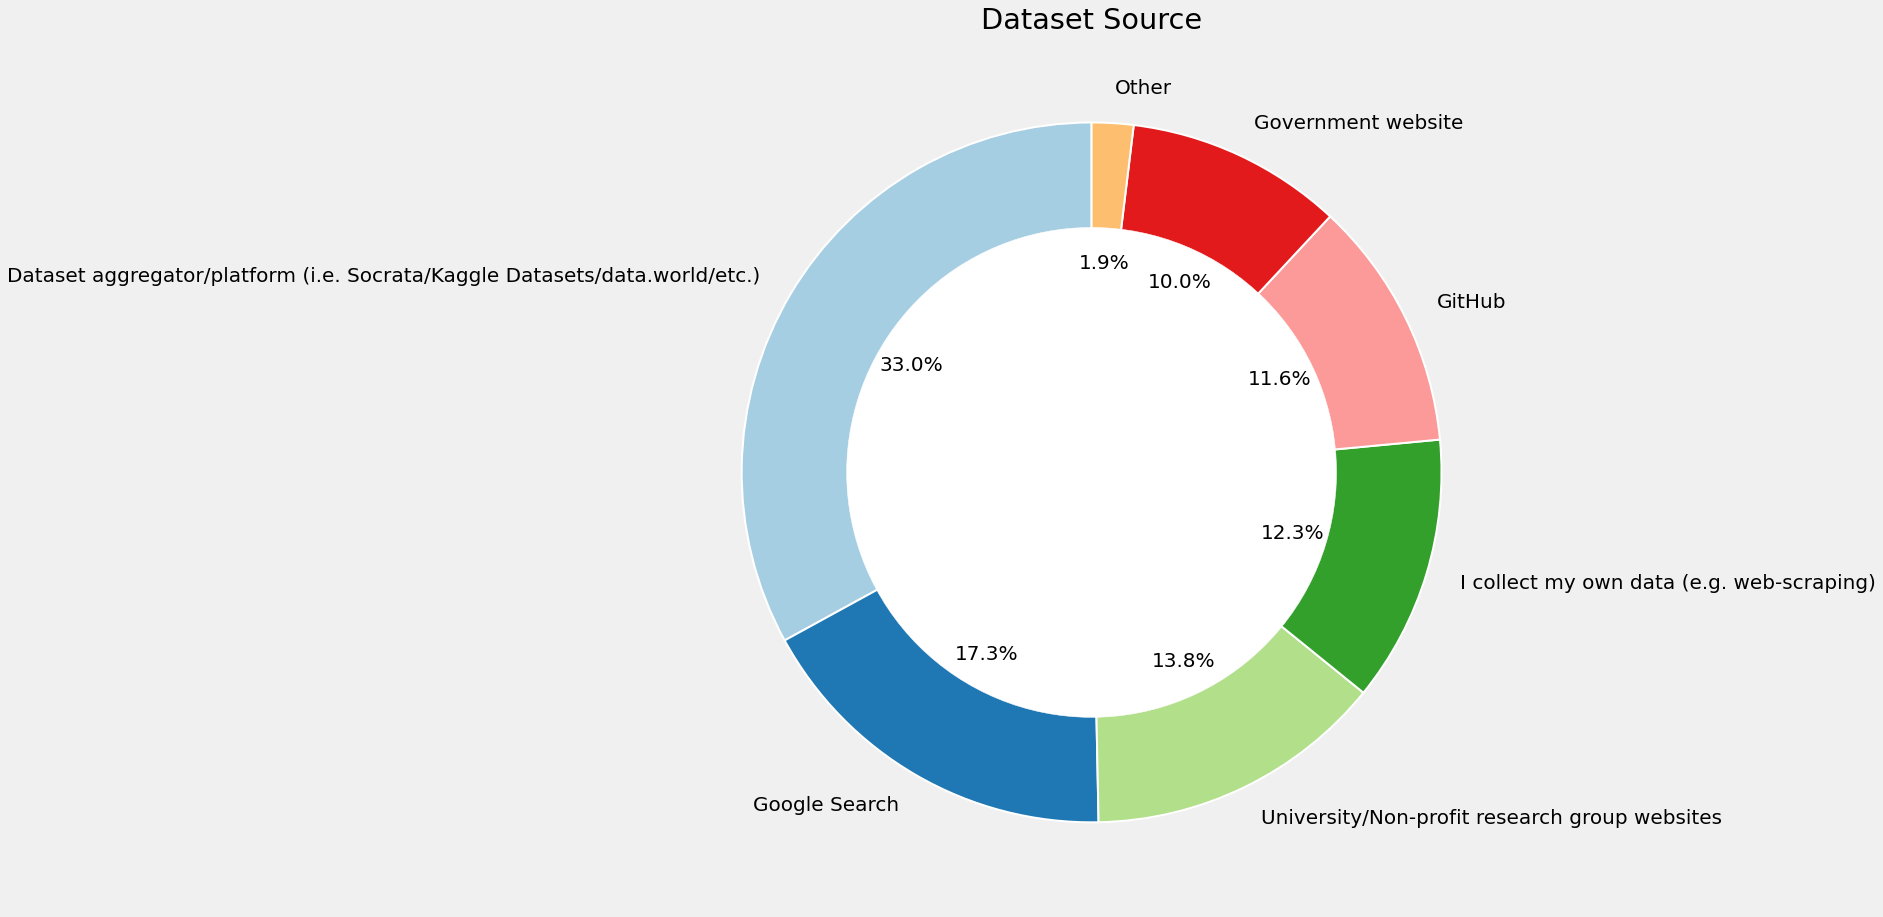

In [23]:
plt.subplots(figsize=(15, 15))
data = response['PublicDatasetsSelect'].str.split(',')
dataset = []
for i in data.dropna():
  dataset.extend(i)
pd.Series(dataset).value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Paired', 10), startangle=90, wedgeprops={'linewidth':2, 'edgecolor':'white'})
plt.title('Dataset Source')
my_circle = plt.Circle((0, 0), 0.7, color='white')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.ylabel('')
plt.show()

- 캐글이 데이터셋을 가장 많이 찾을 수 있는 소스

## Code Sharing

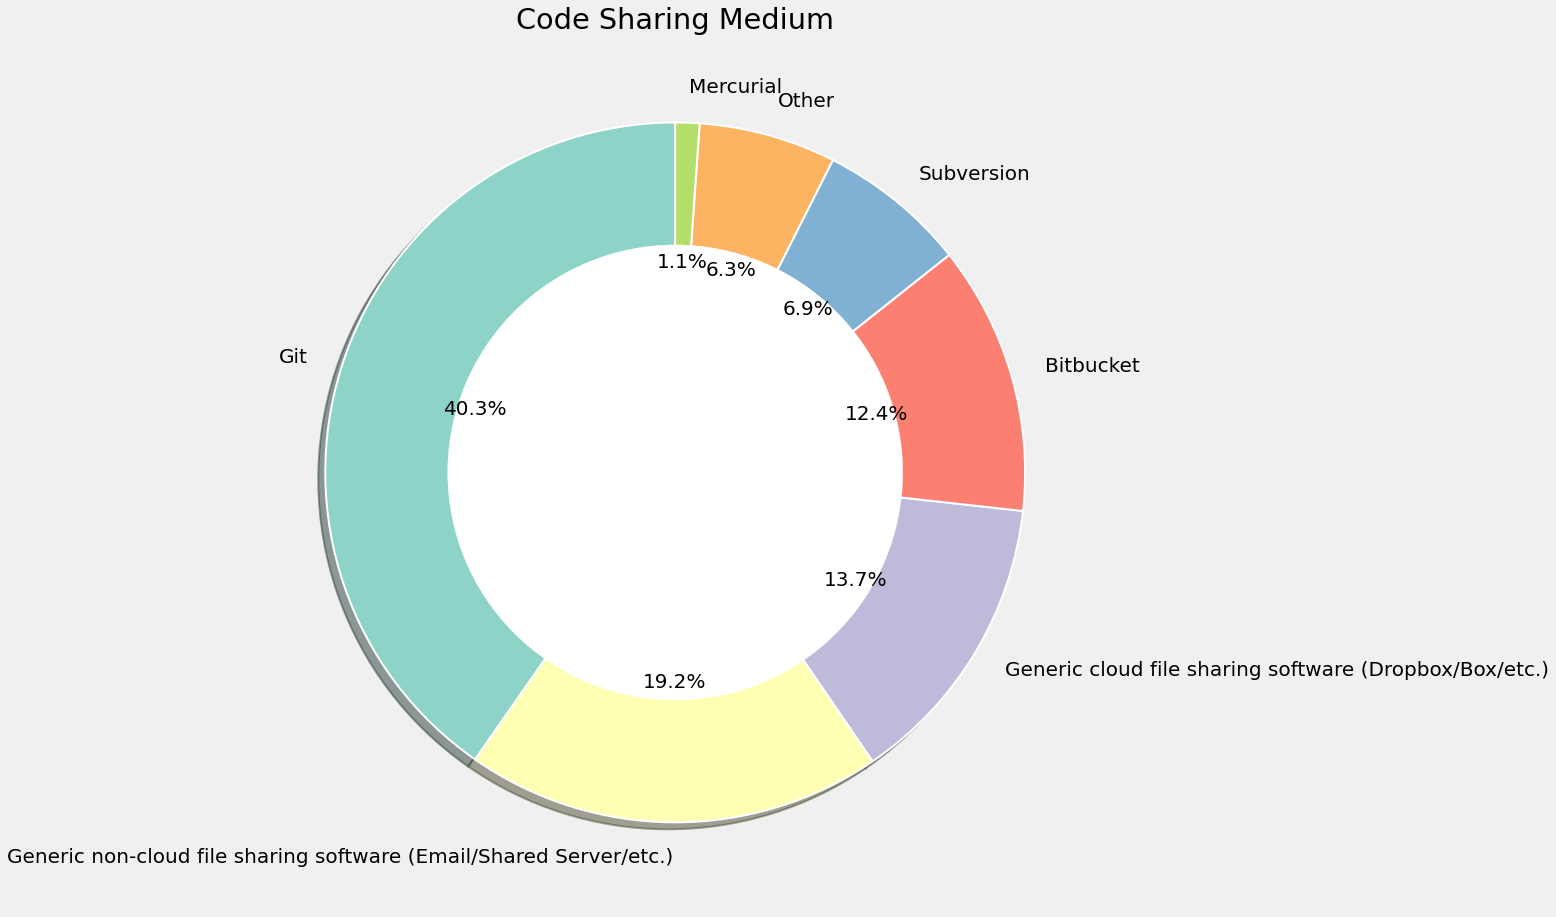

In [24]:
plt.subplots(figsize=(15, 15))
code = response['WorkCodeSharing'].str.split(',')
code_share = []
for i in code.dropna():
  code_share.extend(i)
pd.Series(code_share).value_counts().plot.pie(autopct='%1.1f%%', shadow=True, colors=sns.color_palette('Set3', 10), startangle=90, wedgeprops={'linewidth':2, 'edgecolor':'white'})
plt.title('Code Sharing Medium')
my_circle = plt.Circle((0,0), 0.65, color='white') ##원의 중심, 반지름
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.ylabel('')
plt.show()

- Github이 코드와 프로젝트 공유에 가장 많이 사용되는 플랫폼
- 장점 : 버전 컨트롤 가능, 다른 사람들의 프로젝트 확인 가능, 다른 사람들과 함께 협업 가능

## Challenges in Data Science

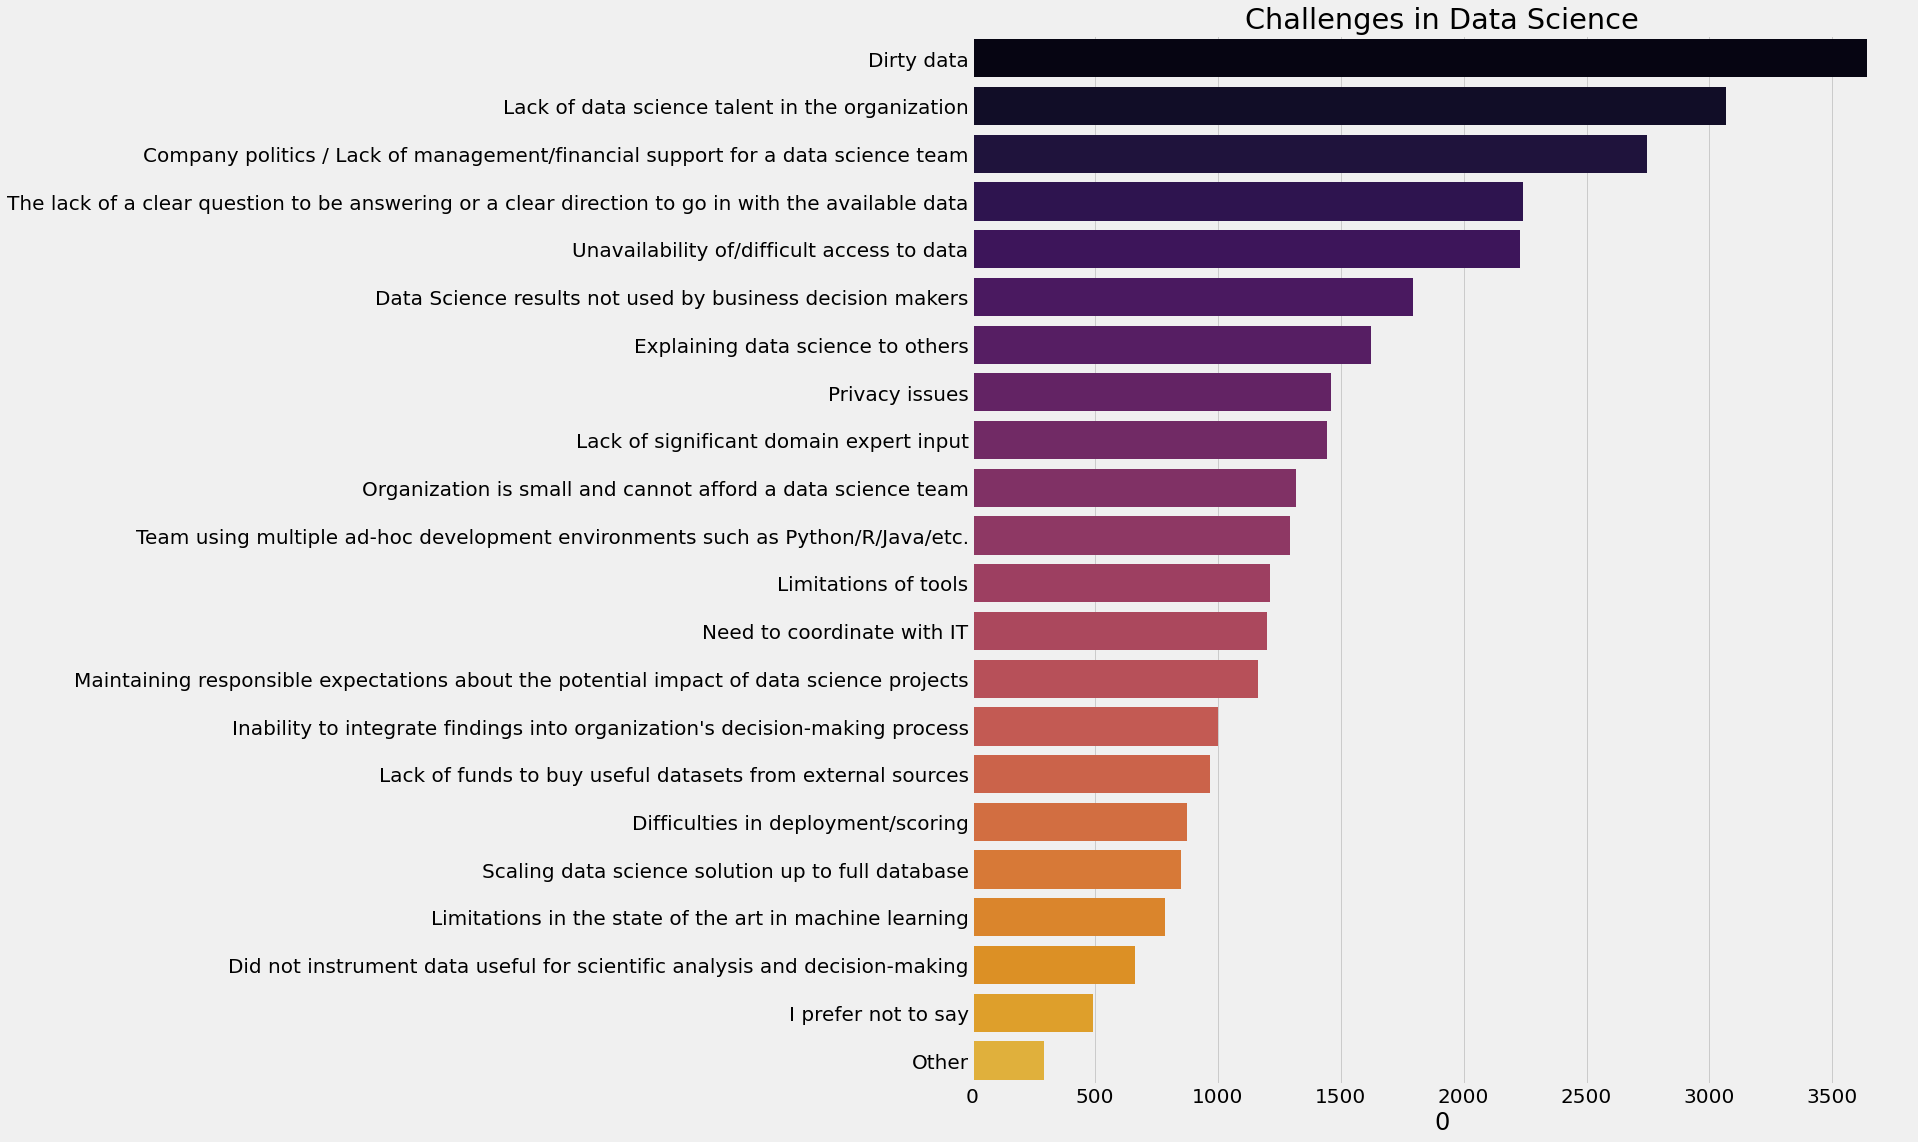

In [25]:
plt.subplots(figsize=(15, 18))
challenge = response['WorkChallengesSelect'].str.split(',')
challenges = []
for i in challenge.dropna():
  challenges.extend(i)
plt1 = pd.Series(challenges).value_counts().sort_values(ascending=False).to_frame()
sns.barplot(plt1[0], plt1.index, palette=sns.color_palette('inferno',25))
plt.title('Challenges in Data Science')
plt.show()

- 가장 큰 문제는 적절한 데이터를 얻기 어려운 것
- Dirty Data는 에러를 포함하고 있는 데이터

## Job Satisfaction

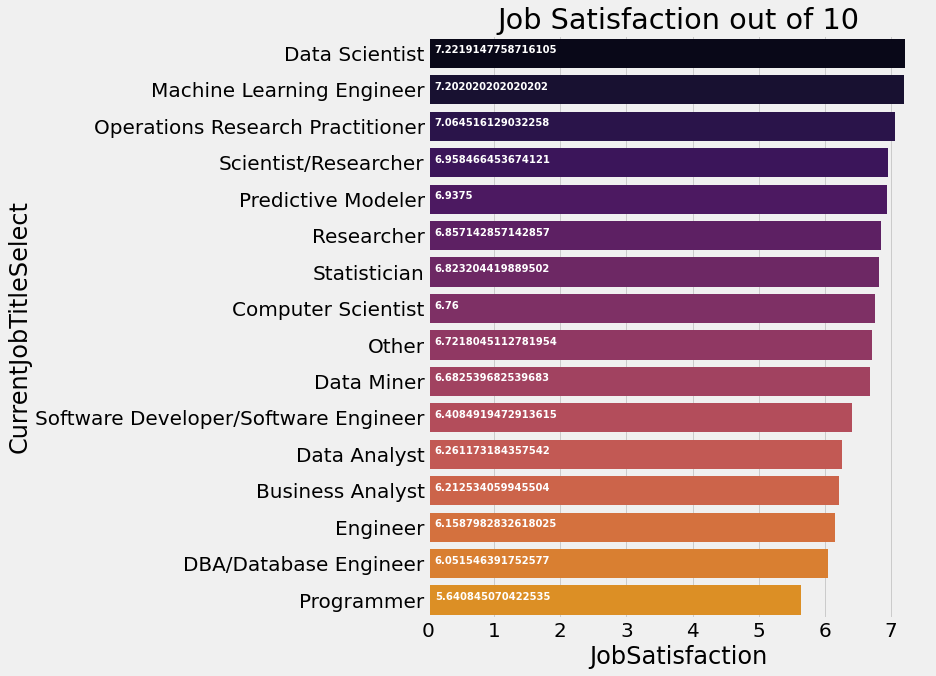

In [26]:
satisfy = response.copy()
satisfy['JobSatisfaction'].replace({'10 - Highly Satisfied':'10', '1 - Highly Dissatisfied':'1', 'I prefer not to share': np.NaN}, inplace=True)
satisfy.dropna(subset=['JobSatisfaction'], inplace=True)
satisfy['JobSatisfaction'] = satisfy['JobSatisfaction'].astype(int)
satisfy_job = satisfy.groupby(['CurrentJobTitleSelect'])['JobSatisfaction'].mean().sort_values(ascending=False).to_frame()
ax = sns.barplot(y=satisfy_job.index, x=satisfy_job.JobSatisfaction, palette=sns.color_palette('inferno',20))
fig = plt.gcf()
fig.set_size_inches(8, 10)
for i, v in enumerate(satisfy_job.JobSatisfaction):
  ax.text(.1, i, v, fontsize=10, color='white', weight='bold')
plt.title('Job Satisfaction out of 10')
plt.show()

- Data Scientist와 ML Engineers가 직업에 가장 만족했으며, 프로그래머가 가장 불만족
- 어떤 Data Scientist는 프로그래머보다도 낮은 급여를 받지만, 그들의 직업 만족도는 높은 것으로 보아 결국 급여가 직무 만족도의 기준은 아닐 듯 --평균적으로 데이터사이언티스트 직군의 급여가 높기 때문에 직업 만족도 또한 높게 측정된것은 아닐까?

## Job Satisfaction By Country

In [27]:
satisfy = response.copy()
satisfy['JobSatisfaction'].replace({'10 - Highly Satisfied':'10','1 - Highly Dissatisfied':'1','I prefer not to share':np.NaN},inplace=True)
satisfy.dropna(subset=['JobSatisfaction'],inplace=True)
satisfy['JobSatisfaction']=satisfy['JobSatisfaction'].astype(int)
satisfy_job = satisfy.groupby(['Country'])['JobSatisfaction'].mean().sort_values(ascending=True).to_frame()

data = [dict(
    type = 'chropleth',
    autocolorscale = False,
    colorscale = 'Viridis',
    reversescale = True,
    showscale = True,
    locations = satisfy_job.index,
    z = satisfy_job['JobSatisfaction'],
    locationmode = 'country names',
    text = satisfy_job['JobSatisfaction'],
    marker = dict(
        line = dict(color='rgb(200, 200, 200)', width=0.5),
        colorbar = dict(autotick=True, tickprefix=''),
        title='Satisfaction')
)]
layout = dict(
    title = 'JobSatisfaction By Country',
    geo = dict(
        showframe = True,
        showocean = True,
        oceancolor = 'rgb(0, 0, 255)',
        projection = dict(
            type = 'chloropleth'),
        lonaxis = dict(showgrid=False, gridcolor='rgb(102, 102, 102)'),
        lataxis = dict(showgrid=False, gridcolor='rgb(102, 102, 102)')
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='worldmap2010')

- 모든 국가에서 평균 직업 만족도는 6-7.5
- 직업 만족도가 가장 낮은 국가는 일본과 중국이며, 스웨덴과 멕시코는에서 만족도가 높음

# Python vs R or (Batman vs Superman)

In [44]:
resp = response.dropna(subset=['WorkToolsSelect'])
resp = resp.merge(rates, left_on='CompensationCurrency', right_on='originCountry', how='left')
python = resp[(resp['WorkToolsSelect'].str.contains('Python'))&(~resp['WorkToolsSelect'].str.contains('R'))]
R = resp[(~resp['WorkToolsSelect'].str.contains('Python'))&(resp['WorkToolsSelect'].str.contains('R'))]
both = resp[(resp['WorkToolsSelect'].str.contains('Python'))&(resp['WorkToolsSelect'].str.contains('R'))]

## Recommended Language For Beginers

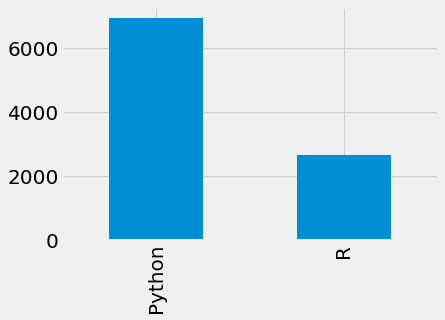

In [29]:
response['LanguageRecommendationSelect'].value_counts()[:2].plot.bar()
plt.show()

- python이 초보자에게 더 추천됨
- 아마 쉬운 영어 구문과 다목적으로 사용가능하기 때문인 듯

## Recommendation By Python and R users

In [30]:
labels1 = python['LanguageRecommendationSelect'].value_counts()[:5].index
sizes1 = python['LanguageRecommendationSelect'].value_counts()[:5].values

labels2 = R['LanguageRecommendationSelect'].value_counts()[:5].index
sizes2 = R['LanguageRecommendationSelect'].value_counts()[:5].values

fig = {
    'data' : [
              {'values':sizes1,
               'labels':labels1,
               'domain':{'x':[0., .48]},
               'name':'Language',
               'hoverinfo':'label+percent+name',
               'hole': .4,
               'type':'pie'},
              {'values':sizes2,
               'labels':labels2,
               #'text':'CO2',
               'textposition':'inside',
               'domain':{'x':[.54, 1]},
               'name':'Language',
               'hoverinfo':'label+percent+name',
               'hole': .4,
               'type':'pie'}
    ],
    'layout':{
        'title' : 'Language Recommended By Python and R users',
        'annotations' : [{'font':{'size':30},
                          'showarrow':False,
                          'text':'Python',
                          'x':0.17,
                          'y':0.5},
                         {'font':{'size':30},
                          'showarrow':False,
                          'text':'R',
                          'x':0.79,
                          'y':0.5}]}
    }
py.iplot(fig, filename='donut')

- python user의 91.6%가 초보자에게 처음 배울 언어로 추천하지만, R user의 67.2%만 초보자에게 추천
- 반면 python user의 1.68%가 R을 처음 배울 언어로 추천하고, R user의 20.6%가 python을 처음 배울 언어로 추천

## Necessary or Not??

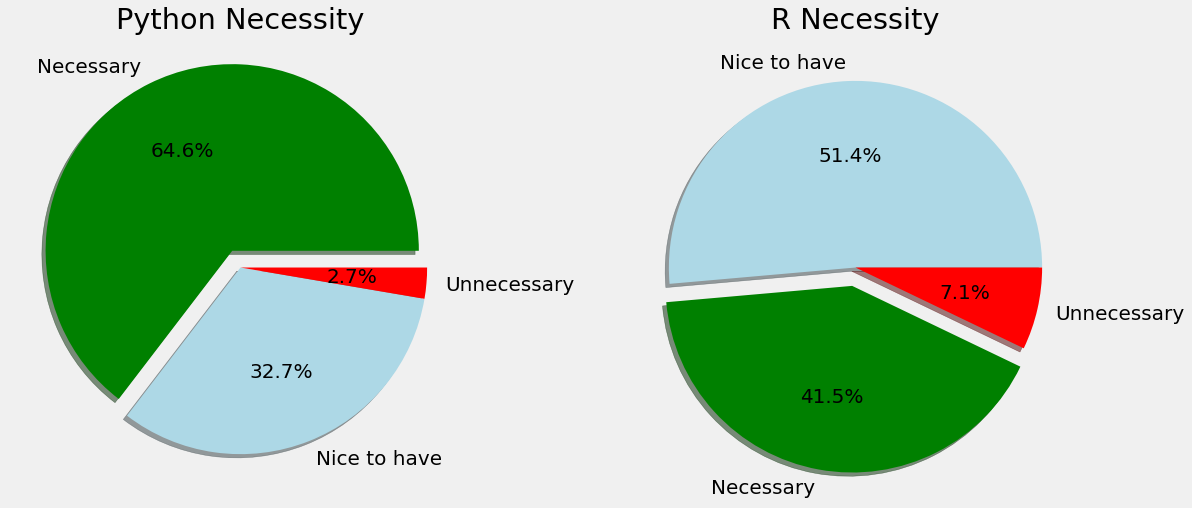

In [31]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
response['JobSkillImportancePython'].value_counts().plot.pie(ax=ax[0],autopct='%1.1f%%',explode=[0.1,0,0],shadow=True,colors=['g','lightblue','r'])
ax[0].set_title('Python Necessity')
ax[0].set_ylabel('')
response['JobSkillImportanceR'].value_counts().plot.pie(ax=ax[1],autopct='%1.1f%%',explode=[0,0.1,0],shadow=True,colors=['lightblue','g','r'])
ax[1].set_title('R Necessity')
ax[1].set_ylabel('')
plt.show()

- R보다 python이 훨씬 필요함

## Number of Users By Language

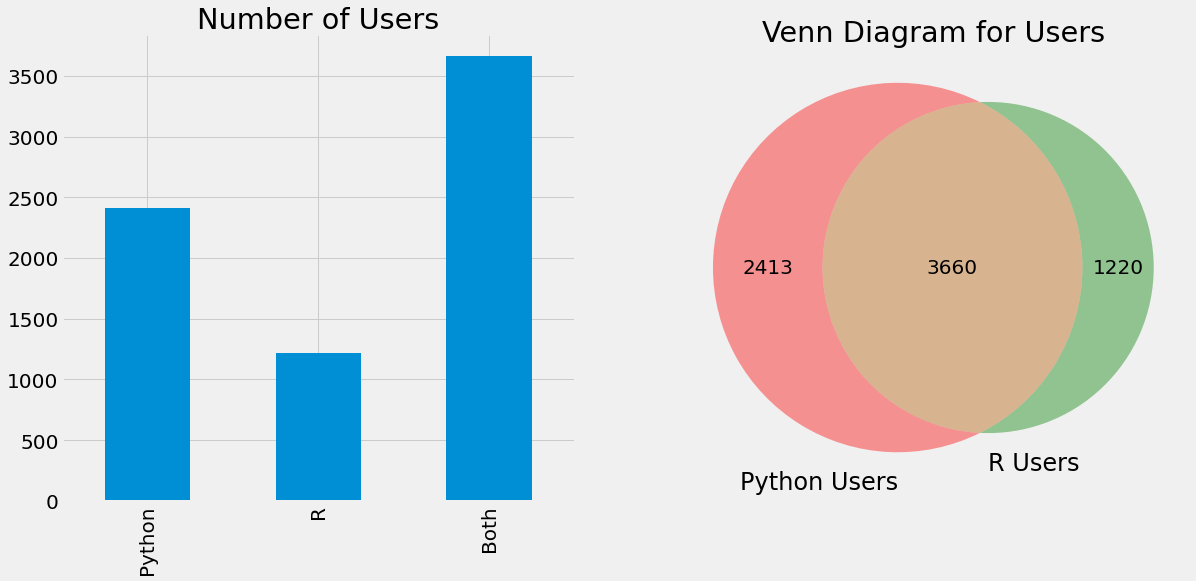

In [45]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
pd.Series([python.shape[0],R.shape[0],both.shape[0]],index=['Python','R','Both']).plot.bar(ax=ax[0])
ax[0].set_title('Number of Users')
venn2(subsets = (python.shape[0], R.shape[0], both.shape[0]), set_labels=('Python Users', 'R Users'))
plt.title('Venn Diagram for Users')
plt.show()

- Python user가 R user보다 많지만 그보다 두가지 언어를 할 수 있는 유저가 더 많음 > 여러가지 언어와 툴을 알고자하는 데이터 사이언티스트들의 응답이기 때문

## Compensation

In [50]:
py_sal = (pd.to_numeric(python['CompensationAmount'].dropna())*python['exchangeRate']).dropna()
py_sal = py_sal[py_sal<1000000]
R_sal = (pd.to_numeric(R['CompensationAmount'].dropna())*R['exchangeRate']).dropna()
R_sal = R_sal[R_sal<1000000]
both_sal = (pd.to_numeric(both['CompensationAmount'].dropna())*both['exchangeRate']).dropna()
both_sal = both_sal[both_sal<1000000]
trying = pd.DataFrame([py_sal, R_sal, both_sal])
trying = trying.transpose()
trying.columns = ['Python', 'R', 'Both']
print('Median Salary For Individual using Python:', trying['Python'].median())
print('Median Salary For Individual using R:', trying['R'].median())
print('Median Salary For Individual using both languages:', trying['Both'].median())

Median Salary For Individual using Python: 48725.600000000006
Median Salary For Individual using R: 48421.99999999999
Median Salary For Individual using both languages: 59791.3


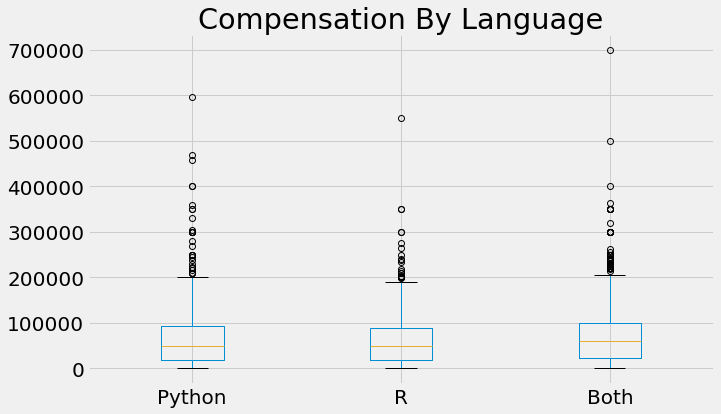

In [51]:
trying.plot.box()
plt.title('Compensation By Language')
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.show()

- 두가지 언어를 하는 사람들의 급여 중앙값이 가장 높음

## Language Used By Professionals

In [54]:
r_vs_py

CurrentJobTitleSelect  ... Age
0         Business Analyst  ...   1
1         Business Analyst  ...   1
2         Business Analyst  ...   1
3         Business Analyst  ...   1
4         Business Analyst  ...   1
...                    ...  ...  ..
2808          Statistician  ...   1
2809          Statistician  ...   6
2810          Statistician  ...   1
2811          Statistician  ...   1
2812          Statistician  ...   2

[2813 rows x 3 columns]

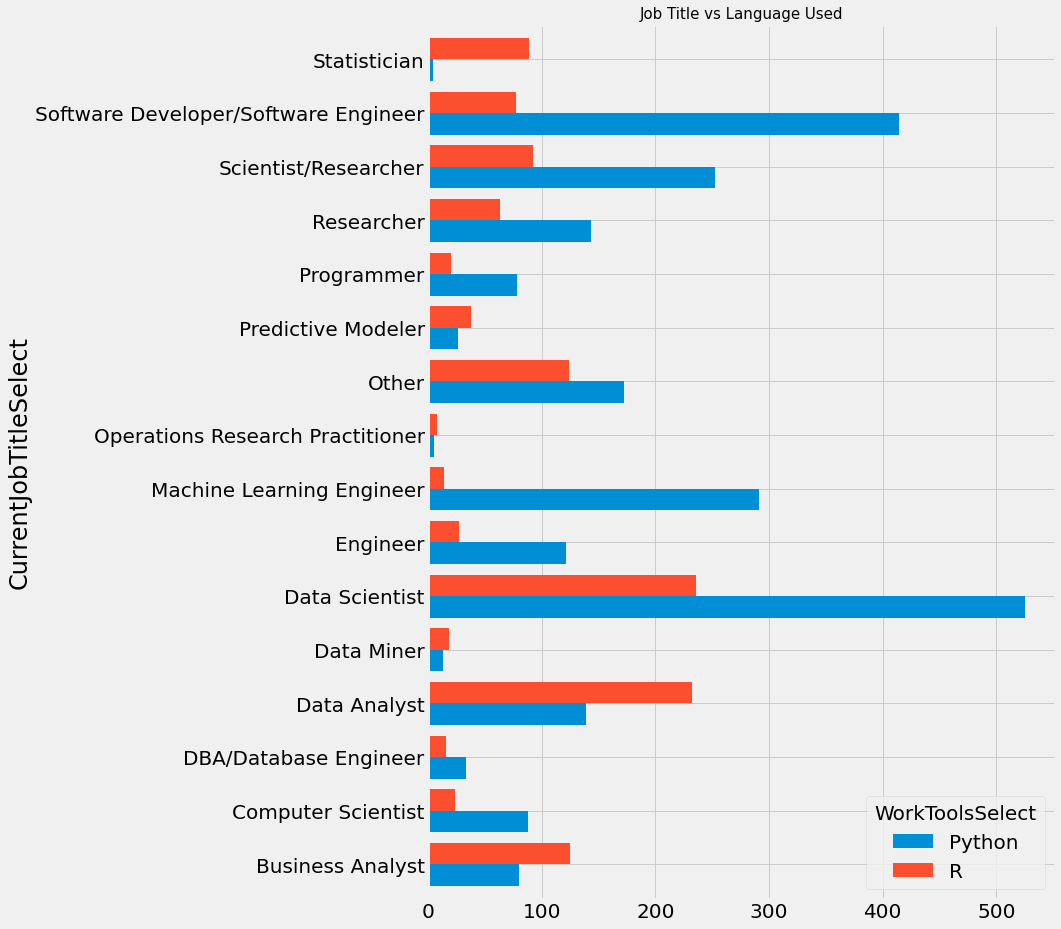

In [57]:
py1 = python.copy()
r = R.copy()
py1['WorkToolsSelect'] = 'Python'
r['WorkToolsSelect'] = 'R'
r_vs_py = pd.concat([py1, r])
r_vs_py = r_vs_py.groupby(['CurrentJobTitleSelect', 'WorkToolsSelect'])['Age'].count().to_frame().reset_index()
r_vs_py.pivot('CurrentJobTitleSelect', 'WorkToolsSelect', 'Age').plot.barh(width=0.8)
fig = plt.gcf()
fig.set_size_inches(10, 15)
plt.title('Job Title vs Language Used', size=15)
plt.show()

- Analytics에서는 R이, ML에서는 Python이 강세

## Tenure vs Language Used

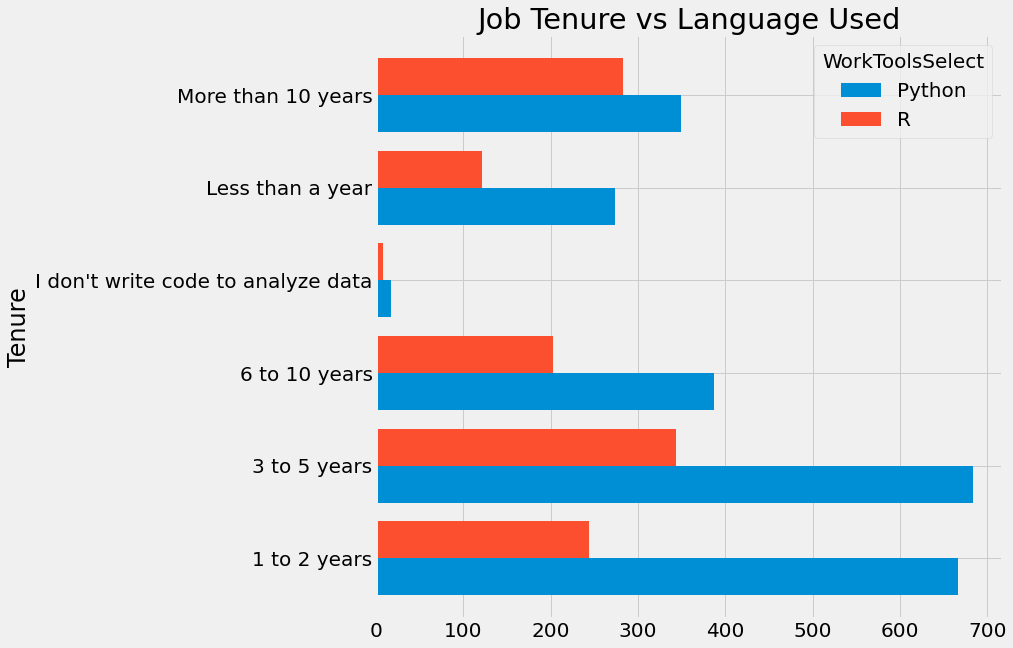

In [59]:
r_vs_py = pd.concat([py1, r])
r_vs_py = r_vs_py.groupby(['Tenure', 'WorkToolsSelect'])['Age'].count().to_frame().reset_index()
r_vs_py.pivot('Tenure', 'WorkToolsSelect', 'Age').plot.barh(width=0.8)
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.title('Job Tenure vs Language Used')
plt.show()

- Python은 초보자들을 위해 추천되므로 코딩 시작할 때 많이 사용되고, 점점 년수가 증가하면서 R과의 간격이 줄어듬

## Industry vs Language Used

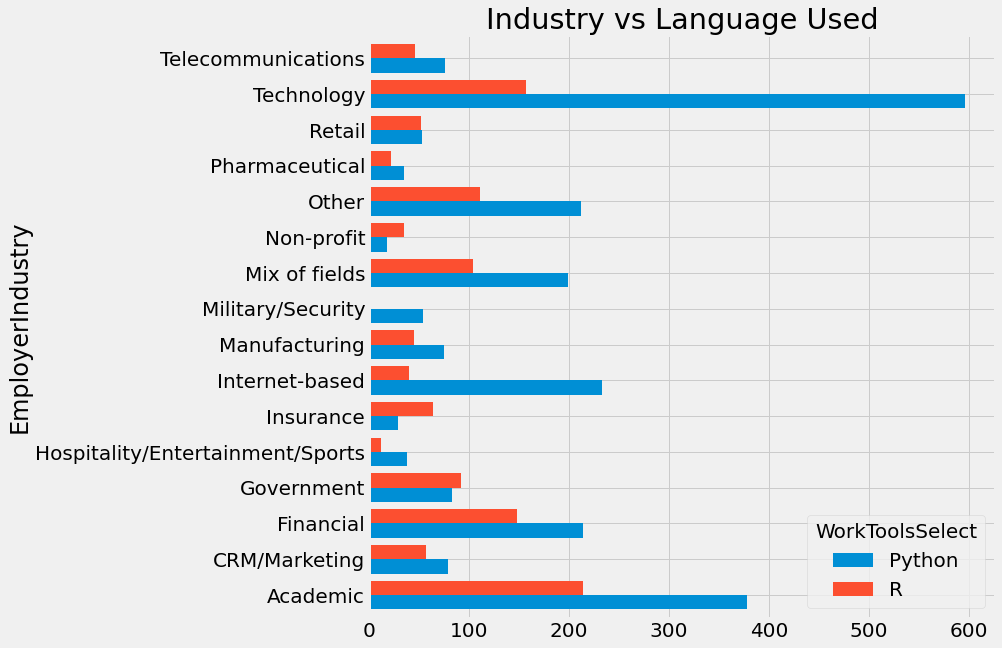

In [62]:
r_vs_py = pd.concat([py1, r])
r_vs_py = r_vs_py.groupby(['EmployerIndustry', 'WorkToolsSelect'])['Age'].count().to_frame().reset_index()
r_vs_py.pivot('EmployerIndustry', 'WorkToolsSelect', 'Age').plot.barh(width=0.8)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Industry vs Language Used')
plt.show()

- R은 Goverment, Insuarance, Non-profit 산업에서 더 많이 사용됨
- Python은 특히 Technology, Military 산업에서 더 많이 사용되고, 대부분 R보다 15-20%정도 더 사용됨

## Common Tools with Python and R

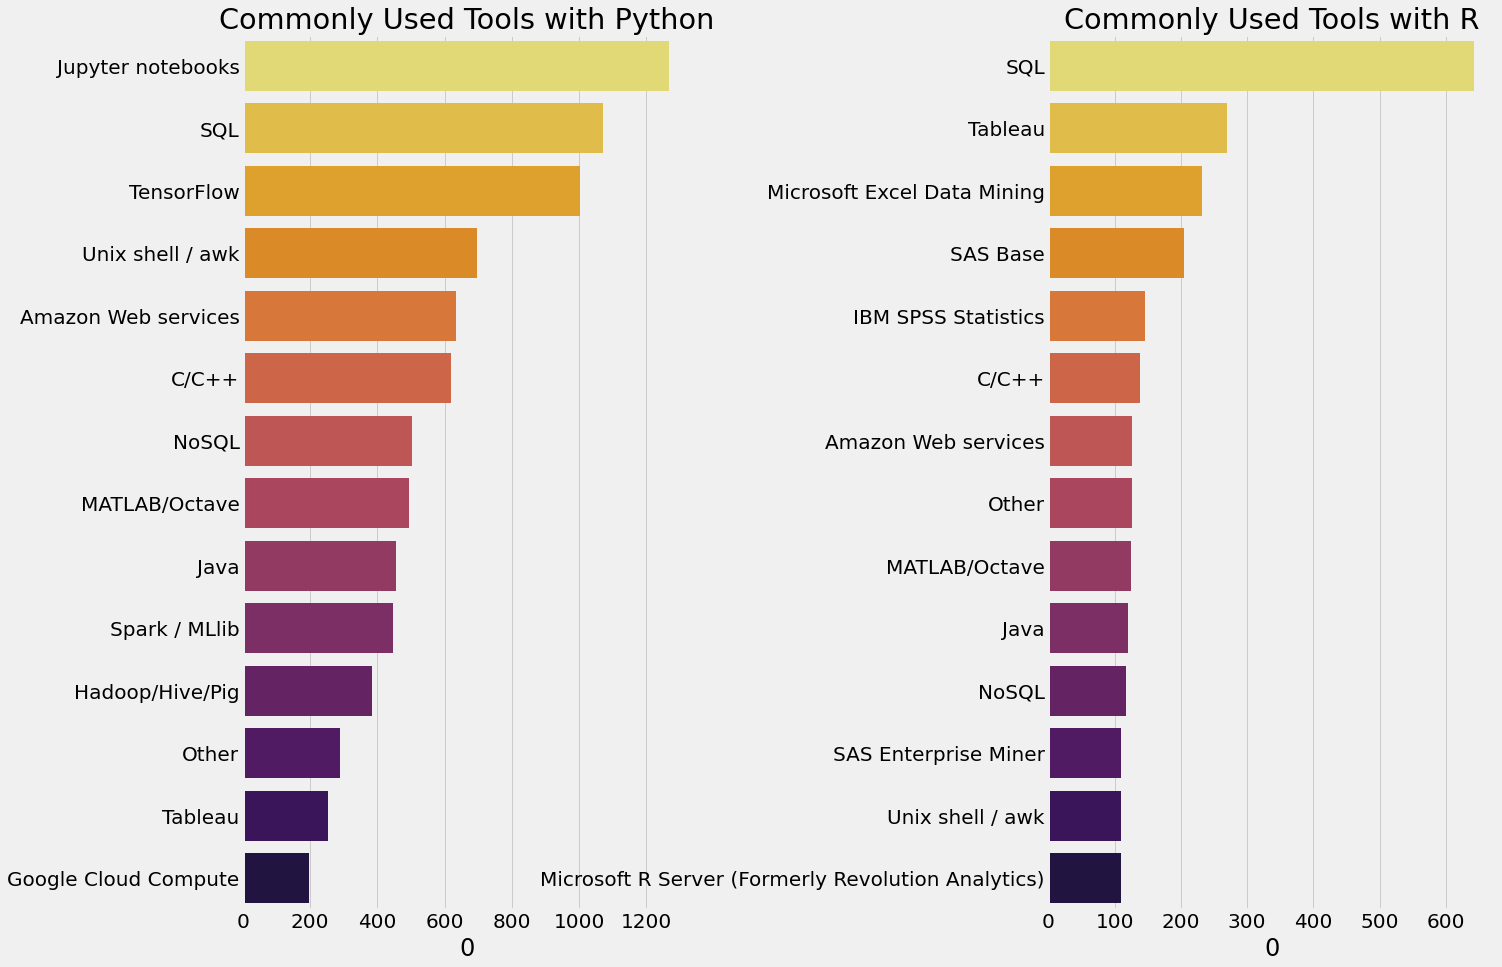

In [65]:
f, ax = plt.subplots(1, 2, figsize=(20, 15))
py_comp = python['WorkToolsSelect'].str.split(',')
py_comp1 = []
for i in py_comp:
  py_comp1.extend(i)
plt1 = pd.Series(py_comp1).value_counts()[1:15].sort_values(ascending=False).to_frame()
sns.barplot(plt1[0], plt1.index, ax=ax[0], palette=sns.color_palette('inferno_r',15))

R_comp = R['WorkToolsSelect'].str.split(',')
R_comp1 = []
for i in R_comp:
  R_comp1.extend(i)
plt1 = pd.Series(R_comp1).value_counts()[1:15].sort_values(ascending=False).to_frame()
sns.barplot(plt1[0], plt1.index, ax=ax[1], palette=sns.color_palette('inferno_r',15))
ax[0].set_title('Commonly Used Tools with Python')
ax[1].set_title('Commonly Used Tools with R')
plt.subplots_adjust(wspace=0.8)
plt.show()

- SQL이 두 언어의 가장 흔히 사용되는 툴

# Asking the Data Scientists

In [66]:
response['DataScienceIdentitySelect'].value_counts()

No                        5314
Yes                       4257
Sort of (Explain more)    3100
Name: DataScienceIdentitySelect, dtype: int64

- 26%만이 스스로 데이터 사이언티스트라고 부름

## Current Job Titles

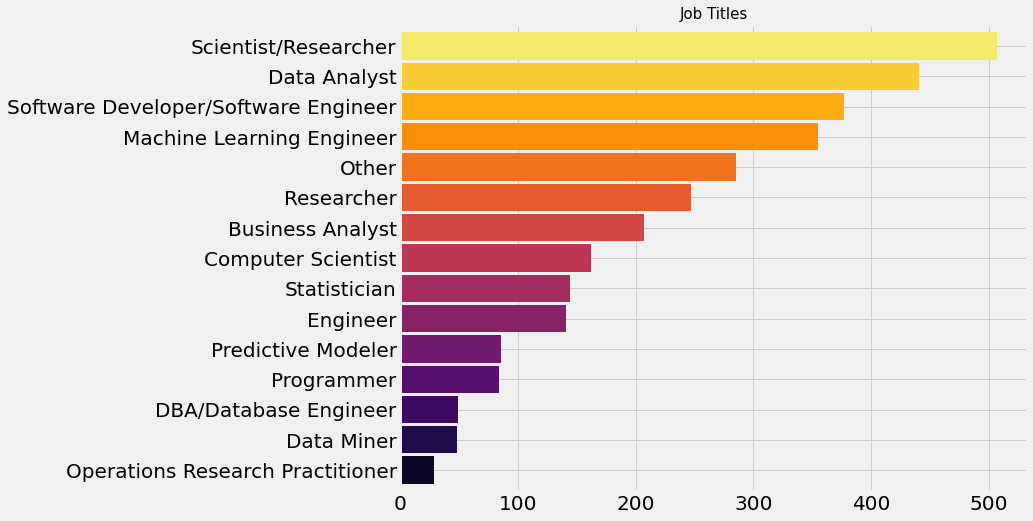

In [67]:
plt.subplots(figsize=(10, 8))
scientist = response[response['DataScienceIdentitySelect']=='Yes']
scientist['CurrentJobTitleSelect'].value_counts().sort_values(ascending=True).plot.barh(width=0.9, color=sns.color_palette('inferno', 15))
plt.title('Job Titles', size=15)
plt.show()

- 놀랍게도 직책에는 데이터 사이언티스트 항목이 없음 > 그래서 데이터 사이언티스트라고 본인을 생각하지 않을수도..

In [68]:
true = response[response['CurrentJobTitleSelect']=='Data Scientist']

In [69]:
scientist = pd.concat([scientist, true])
scientist['CurrentJobTitleSelect'].shape[0]

6690

- 전체 응답자 중 40%가 데이터 사이언티스트이거나 같은 분야에 대한 기술을 가지고 있음

## Country-Wise Split

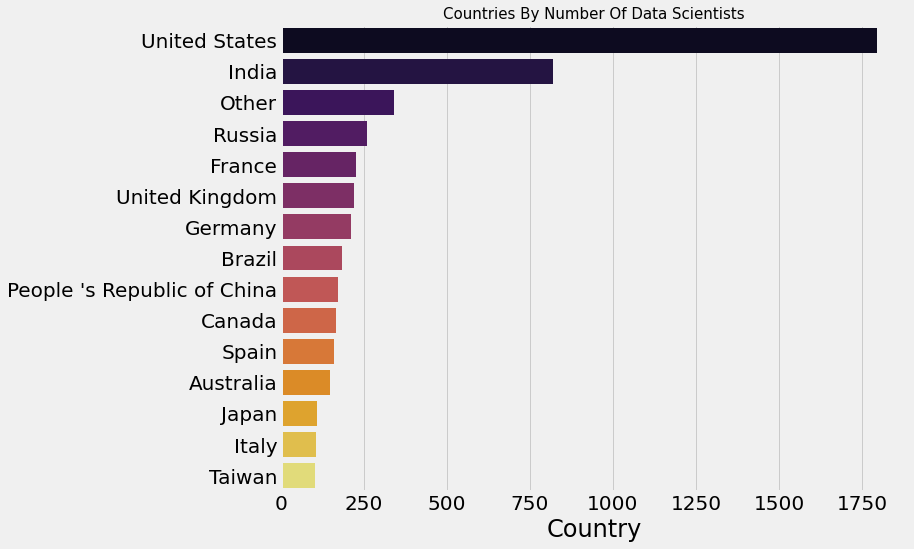

In [70]:
plt.subplots(figsize=(10, 8))
coun = scientist['Country'].value_counts()[:15].sort_values(ascending=False).to_frame()
sns.barplot(coun.Country, coun.index, palette='inferno')
plt.title('Countries By Number Of Data Scientists', size=15)
plt.show()

- 국가별 사용자 분포와 비슷

## Employment Status & Education

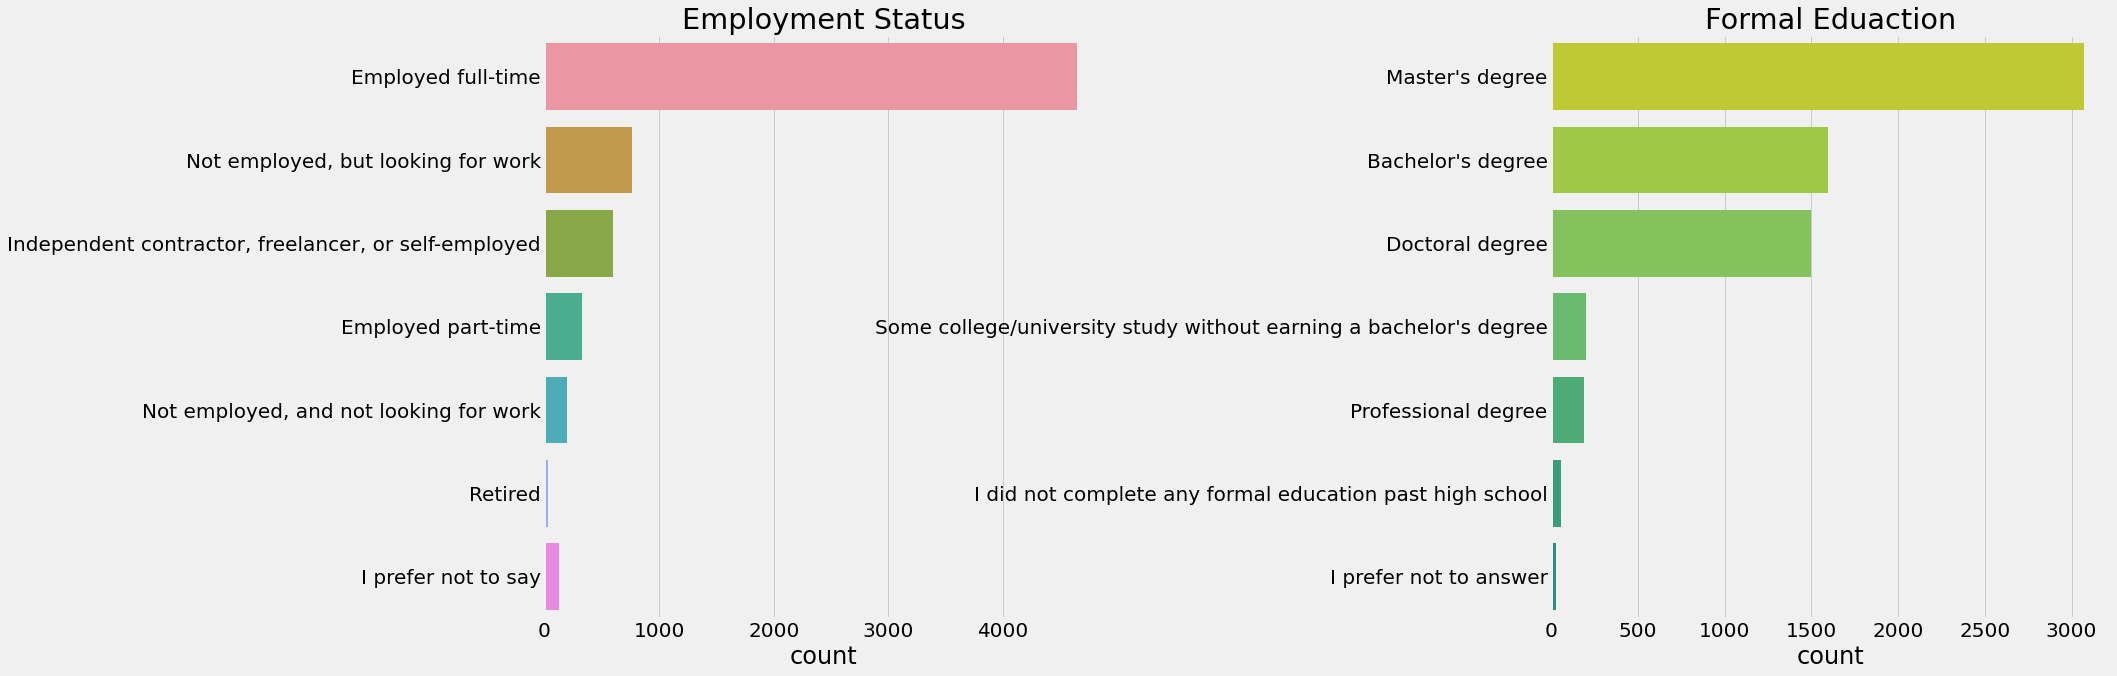

In [71]:
f, ax = plt.subplots(1, 2, figsize=(25, 10))
sns.countplot(y=scientist['EmploymentStatus'], ax=ax[0])
ax[0].set_title('Employment Status')
ax[0].set_ylabel('')

sns.countplot(y=scientist['FormalEducation'], order=scientist['FormalEducation'].value_counts().index,ax=ax[1], palette=sns.color_palette('viridis_r', 15))
ax[1].set_title('Formal Eduaction')
ax[1].set_ylabel('')
plt.subplots_adjust(wspace=0.8)
plt.show()

- 67%의 데이터 사이언티스트는 풀타임으로, 11-12%는 직장을 찾고 있음
- 45-46%의 데이터 사이언티스는 석사이고, 23-24%는 학사
- 교육이 데이터 사이언티스트가 되는 것에 중요한 영향을 미치는 것으로 보임

## Compensation By Formal Education

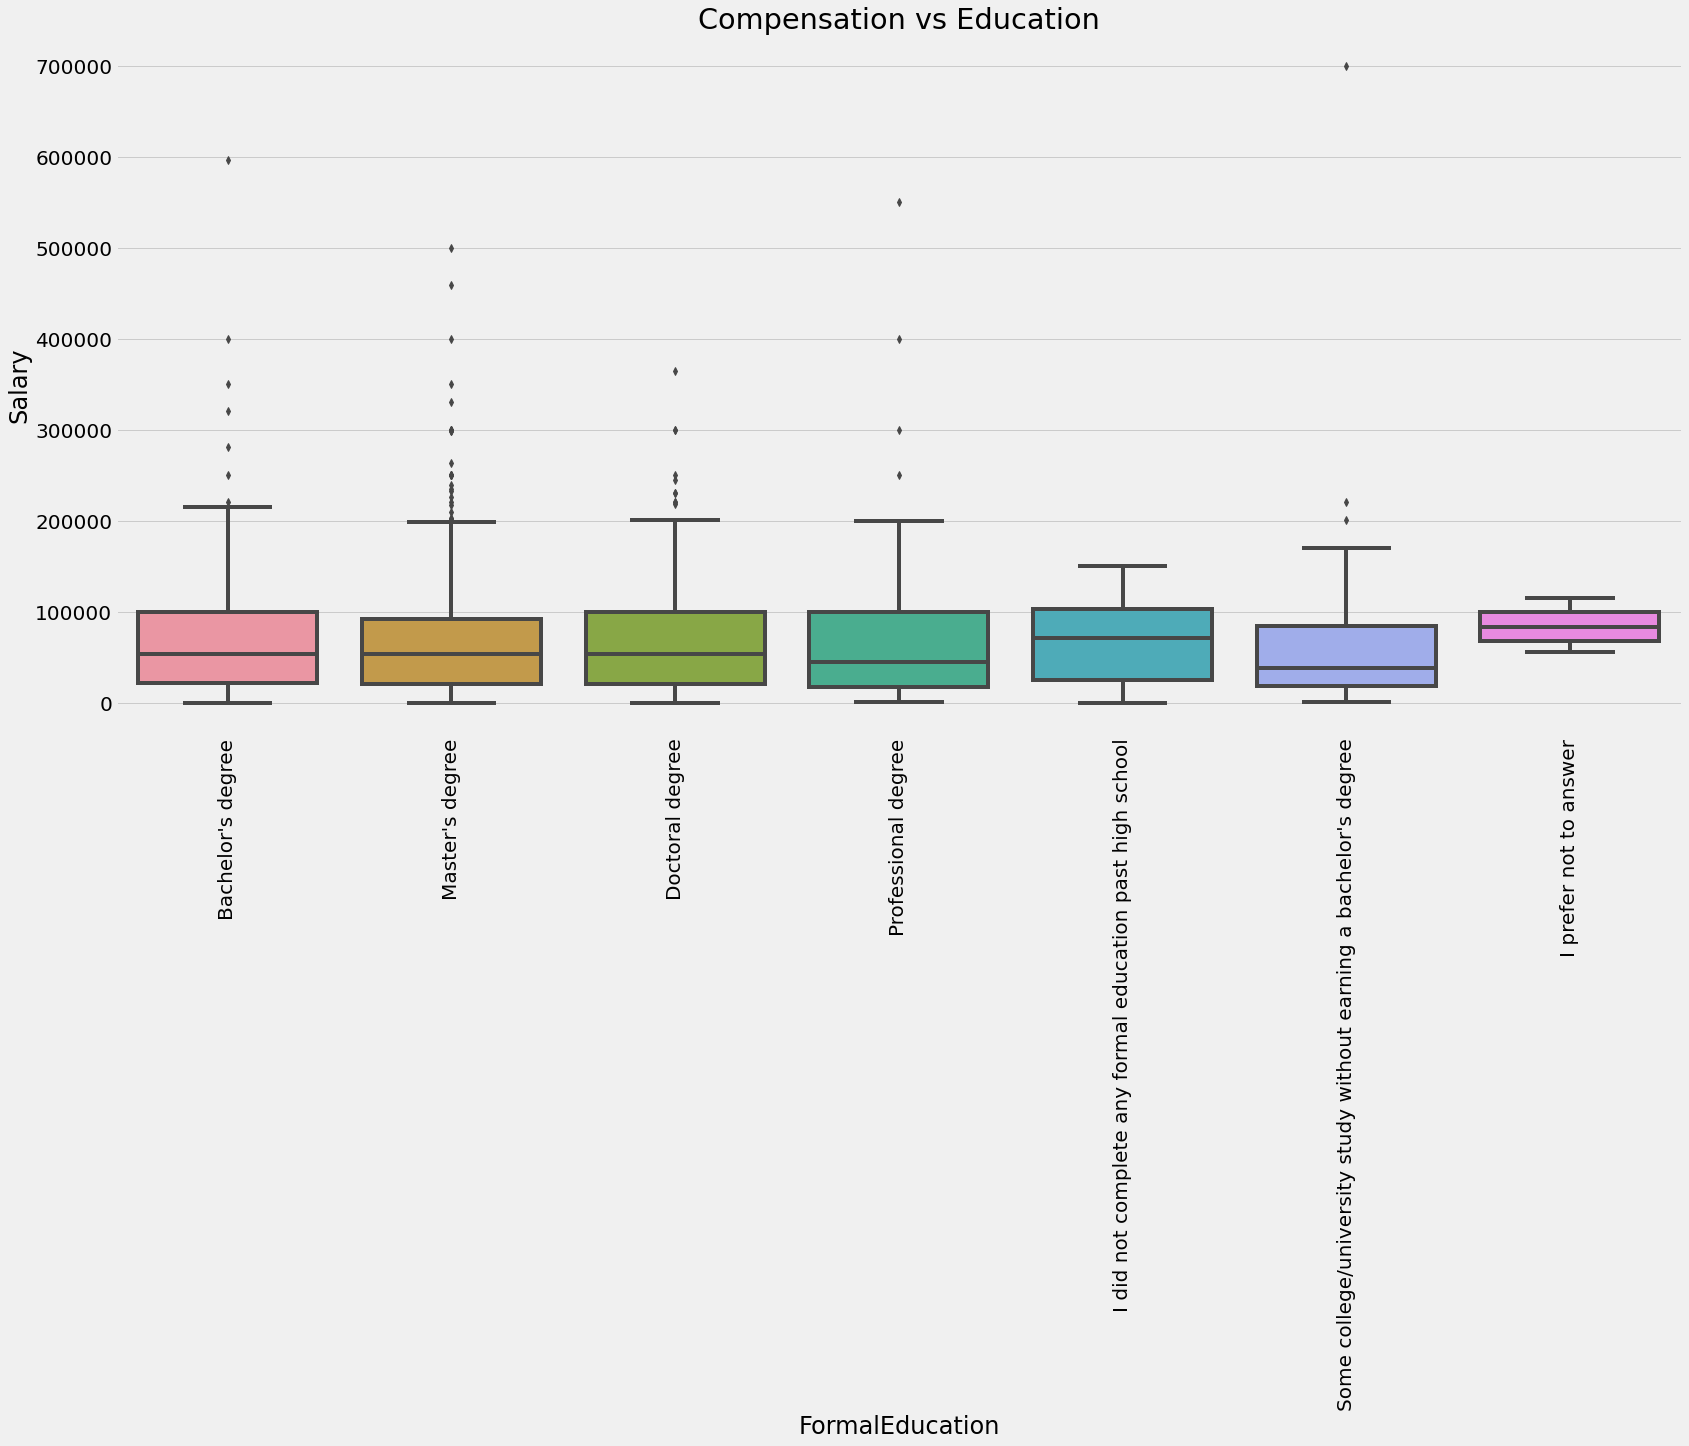

In [74]:
plt.subplots(figsize=(25, 12))
comp_edu = scientist.merge(salary, left_index=True, right_index=True, how='left')
comp_edu = comp_edu[['FormalEducation', 'Salary']]
sns.boxplot(x='FormalEducation', y='Salary', data=comp_edu)
plt.title('Compensation vs Education')
plt.xticks(rotation=90)
plt.show()

- 학사, 석사, 박사의 급여는 비슷함
- 근무 경험이 더 중요한 것으로 보임

## Previous Job and Salary Change

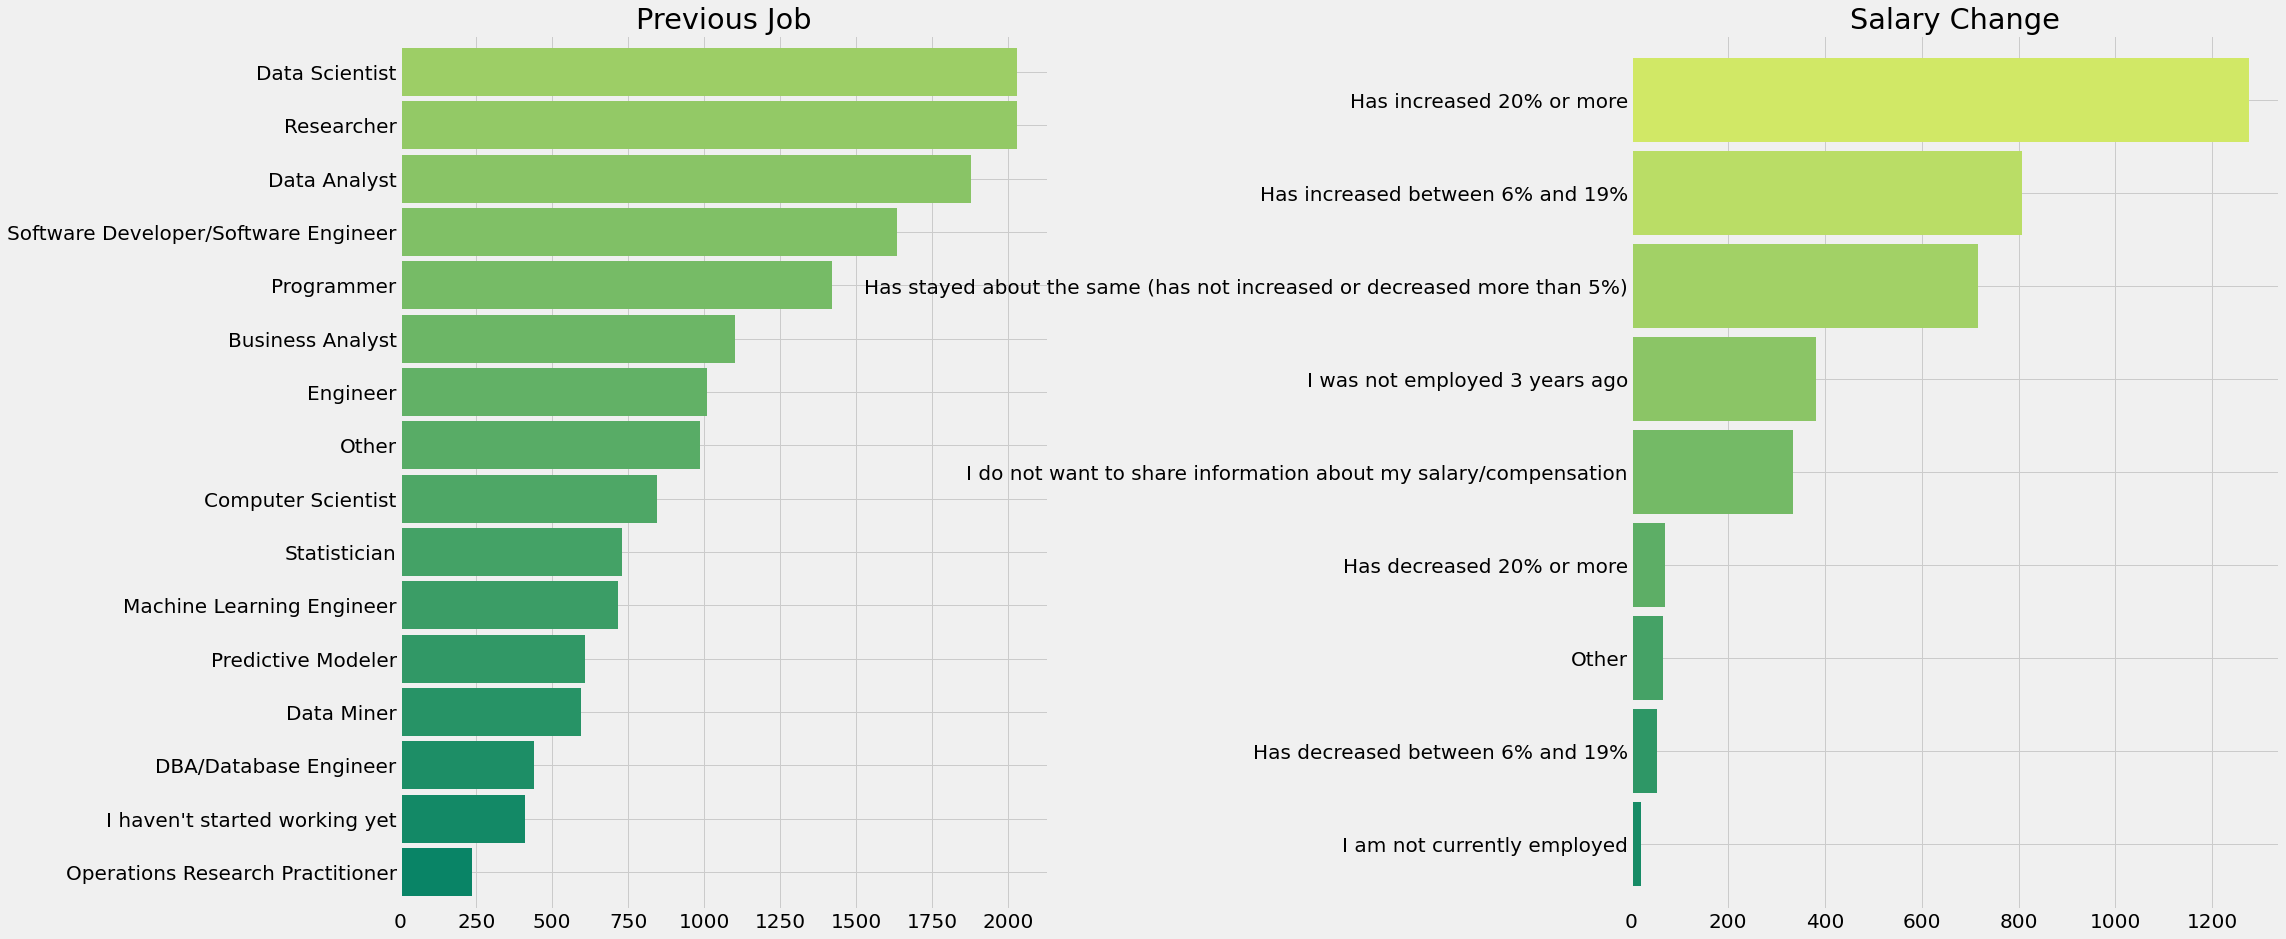

In [75]:
f, ax = plt.subplots(1, 2, figsize=(30, 15))
past = scientist['PastJobTitlesSelect'].str.split(',')
past_job = []
for i in past.dropna():
  past_job.extend(i)
pd.Series(past_job).value_counts().sort_values(ascending=True).plot.barh(width=0.9, color=sns.color_palette('summer',25),ax=ax[0])
ax[0].set_title('Previous Job')
sal = scientist['SalaryChange'].str.split(',')
sal_change = []
for i in sal.dropna():
    sal_change.extend(i)
pd.Series(sal_change).value_counts().sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('summer',10),ax=ax[1])
ax[1].set_title('Salary Change')
plt.subplots_adjust(wspace=0.9)
plt.show()

- 데이터 사이언스로 전환한 대부분의 사람들은 6-20% 급여 인상이 있었음 > 데이터 사이언티스트에 대한 수요가 증가하면서 급여도 증가

## Tools used at Work

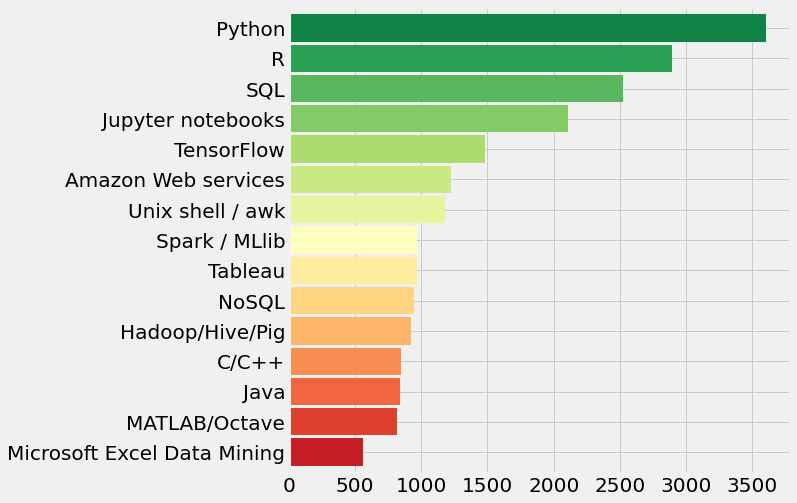

In [76]:
plt.subplots(figsize=(8, 8))
tools = scientist['WorkToolsSelect'].str.split(',')
tools_work = []
for i in tools.dropna():
  tools_work.extend(i)
pd.Series(tools_work).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('RdYlGn',15))
plt.show()

- 데이터 사이언티스트는 Python, R, SQL을 가장 많이 사용

## Where did the learn from??

In [78]:
course = scientist['CoursePlatformSelect'].str.split(',')
course_plat = []
for i in course.dropna():
    course_plat.extend(i)
course_plat = pd.Series(course_plat).value_counts()

blogs = scientist['BlogsPodcastsNewslettersSelect'].str.split(',')
blogs_fam = []
for i in blogs.dropna():
    blogs_fam.extend(i)
blogs_fam=pd.Series(blogs_fam).value_counts()
labels1=course_plat.index
sizes1=course_plat.values
labels2=blogs_fam[:5].index
sizes2=blogs_fam[:5].values

fig = {
  "data": [
    {
      "values": sizes1,
      "labels": labels1,
      "domain": {"x": [0, .48]},
      "name": "MOOC",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    },     
    {
      "values": sizes2 ,
      "labels": labels2,
      #"text":"CO2",
      "textposition":"inside",
      "domain": {"x": [.54, 1]},
      "name": "Blog",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title":"Blogs and Online Platforms",
        "showlegend":True,
        "annotations": [
            {
                "font": {
                    "size": 12
                },
                "showarrow": False,
                "text": "MOOC's",
                "x": 0.18,
                "y": 0.5
            },
            {
                "font": {
                    "size": 12
                },
                "showarrow": False,
                "text": "BLOGS",
                "x": 0.83,
                "y": 0.5}]}}
py.iplot(fig, filename='donut')

- Coursera가 가장 많이 선호되는 플랫폼

## Time spendt on Tasks

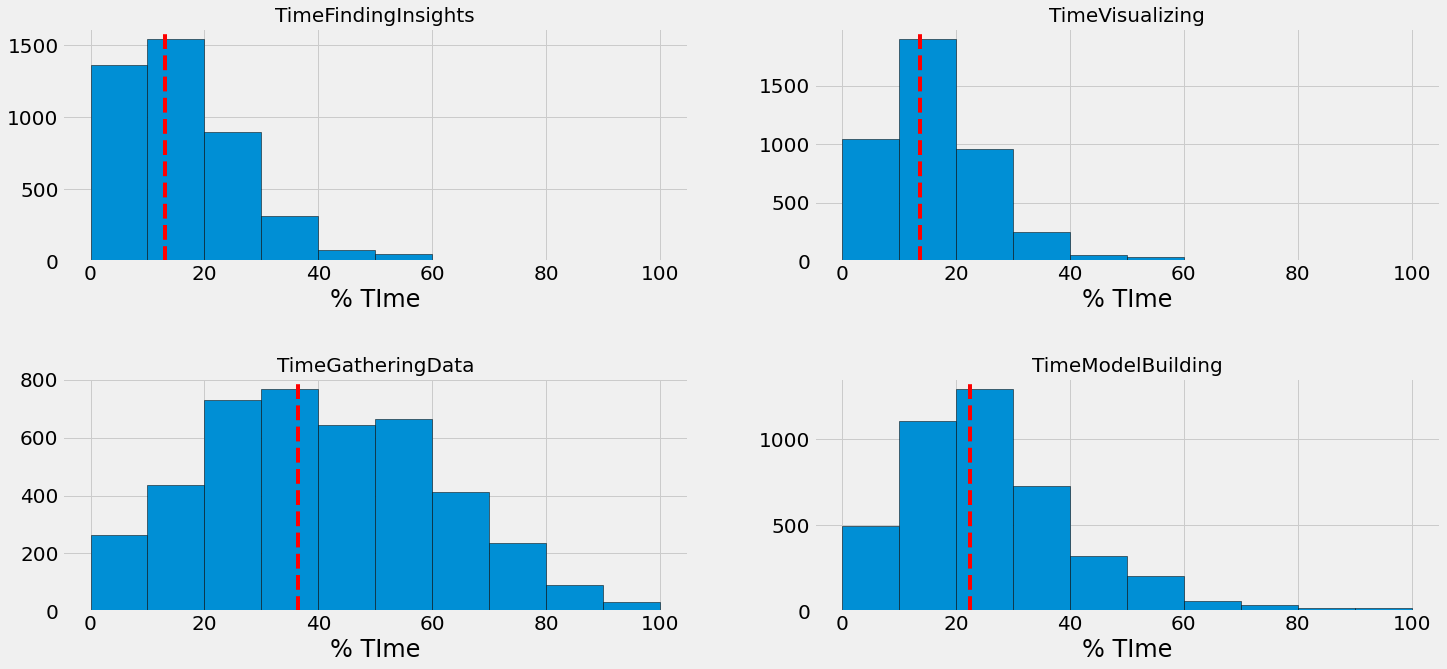

In [80]:
import itertools
plt.subplots(figsize=(22, 10))
time_spent = ['TimeFindingInsights','TimeVisualizing','TimeGatheringData','TimeModelBuilding']
length = len(time_spent)
for i, j in itertools.zip_longest(time_spent, range(length)):
  plt.subplot((length/2), 2, j+1)
  plt.subplots_adjust(wspace=0.2, hspace=0.5)
  scientist[i].hist(bins=10, edgecolor='black')
  plt.axvline(scientist[i].mean(), linestyle='dashed', color='r')
  plt.title(i, size=20)
  plt.xlabel('% TIme')

plt.show()

- 데이터 수집 : 가장 긴 시간이 소요되는 작업. 올바른 데이터를 수집하고 처리하는데 가장 많은 시간 소요
- 데이터 시각화 : 가장 적은 시간이 소요되는 작업
- 인사이트 발견 : 시각화에 비해 조금 더 긴 시간이 소요
- 모델링 : 예측모델 만들고 조정하는 작업으로 데이터 수집 다음으로 긴 시간 소요

## Cloud Services

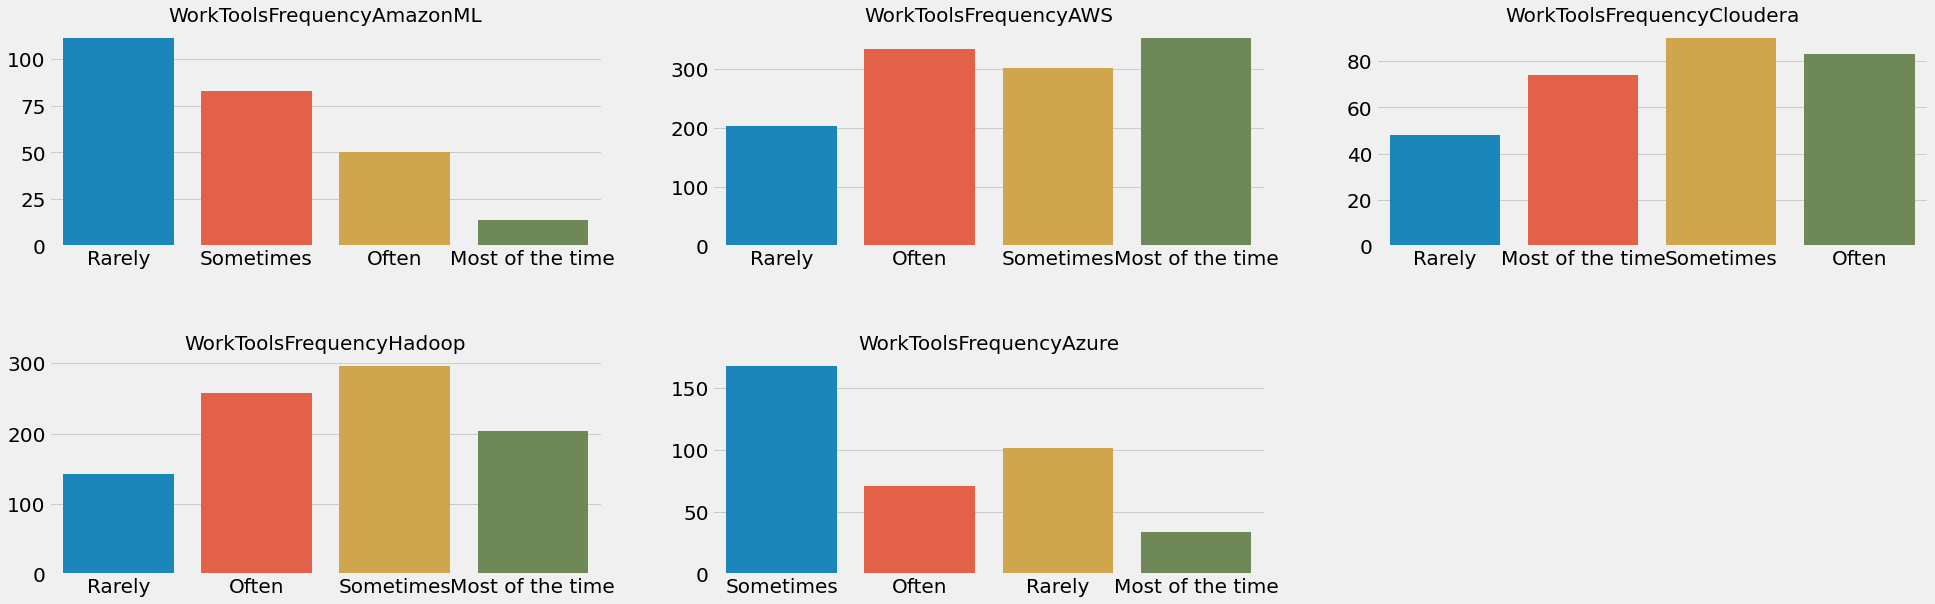

In [85]:
cloud = ['WorkToolsFrequencyAmazonML','WorkToolsFrequencyAWS','WorkToolsFrequencyCloudera','WorkToolsFrequencyHadoop','WorkToolsFrequencyAzure']
plt.subplots(figsize=(30,15))
length = len(cloud)
for i,j in itertools.zip_longest(cloud,range(length)):
    plt.subplot((length/2+1),3,j+1)
    plt.subplots_adjust(wspace=0.2,hspace=0.5)
    sns.countplot(i,data=scientist)
    plt.title(i,size=20)
    plt.ylabel('')
    plt.xlabel('')
plt.show()

- AmazonAWS가 가장 많이 사용되는 클라우드 플랫폼이며, 다음으로 하둡을 많이 사용

## Importance of visualisations

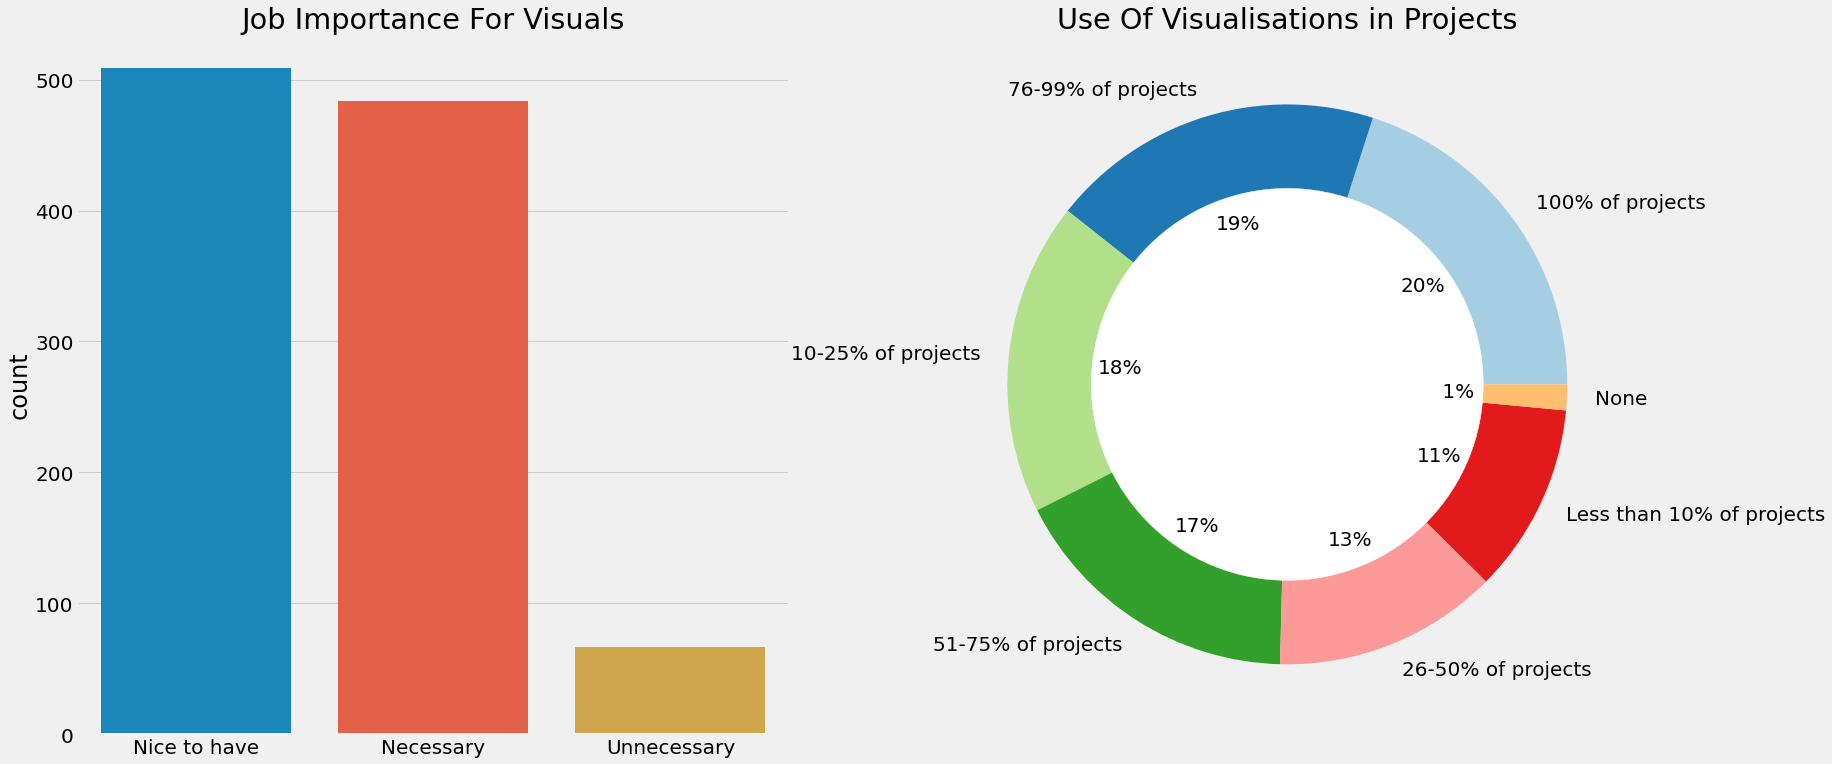

In [86]:
f, ax = plt.subplots(1, 2, figsize=(25, 12))
sns.countplot(scientist['JobSkillImportanceVisualizations'], ax=ax[0])
ax[0].set_title('Job Importance For Visuals')
ax[0].set_xlabel('')

scientist['WorkDataVisualizations'].value_counts().plot.pie(autopct='%2.0f%%', colors=sns.color_palette('Paired',10),ax=ax[1])
ax[1].set_title('Use Of Visualisations in Projects')
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.ylabel('')
plt.show()

- 시각화는 데이터 사이언스 프로젝트에 필수적인 부분

## BI Tools

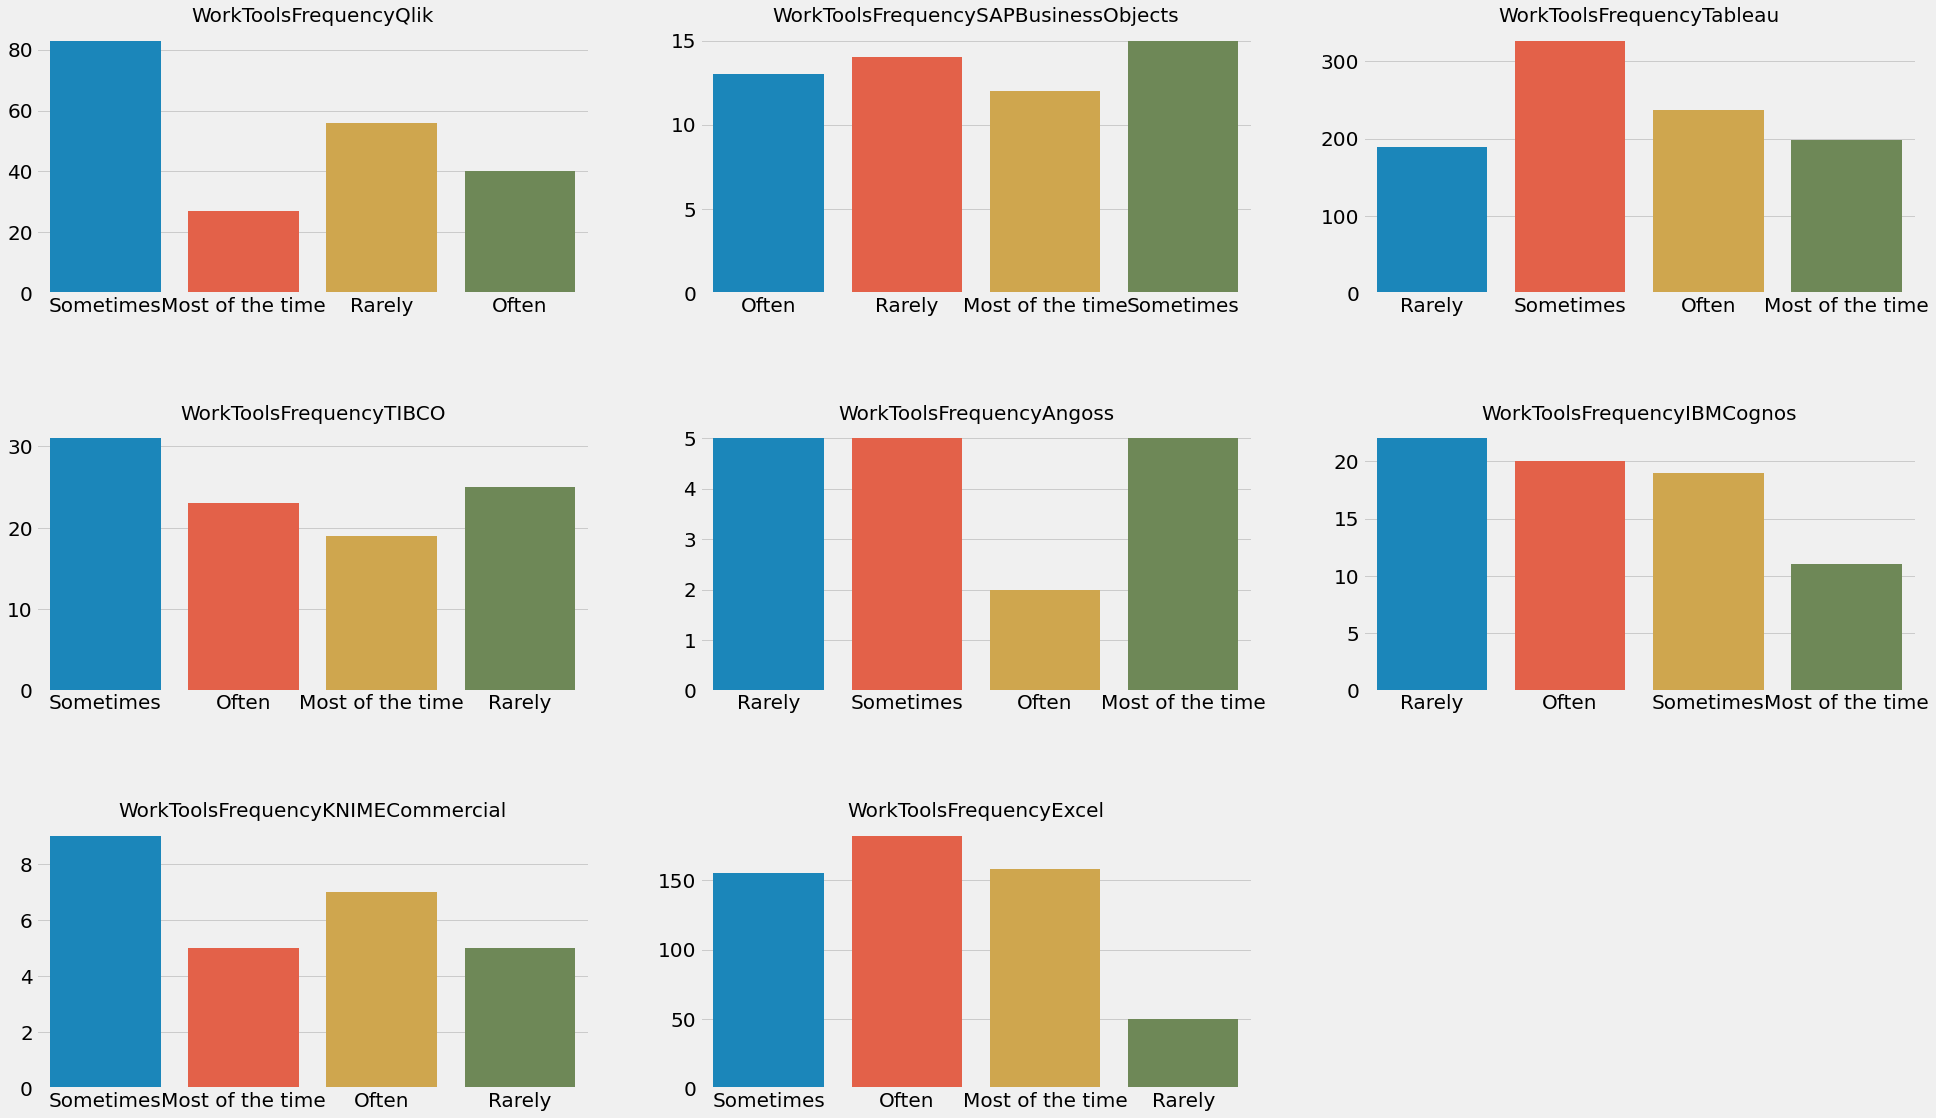

In [87]:
BI = ['WorkToolsFrequencyQlik','WorkToolsFrequencySAPBusinessObjects','WorkToolsFrequencyTableau','WorkToolsFrequencyTIBCO','WorkToolsFrequencyAngoss','WorkToolsFrequencyIBMCognos','WorkToolsFrequencyKNIMECommercial','WorkToolsFrequencyExcel']
plt.subplots(figsize=(30, 25))
length = len(BI)
for i,j in itertools.zip_longest(BI,range(length)):
    plt.subplot((length/2),3,j+1) ## nrows, ncols, index
    plt.subplots_adjust(wspace=0.2,hspace=0.5)
    sns.countplot(i,data=scientist)
    plt.title(i,size=20)
    plt.ylabel('')
    plt.xlabel('')
plt.show()

- 엑셀이 여전히 가장 인기있는 도구이고, 다음은 Tableau 순

## Knowledge of Algorithms (Maths and Stats)

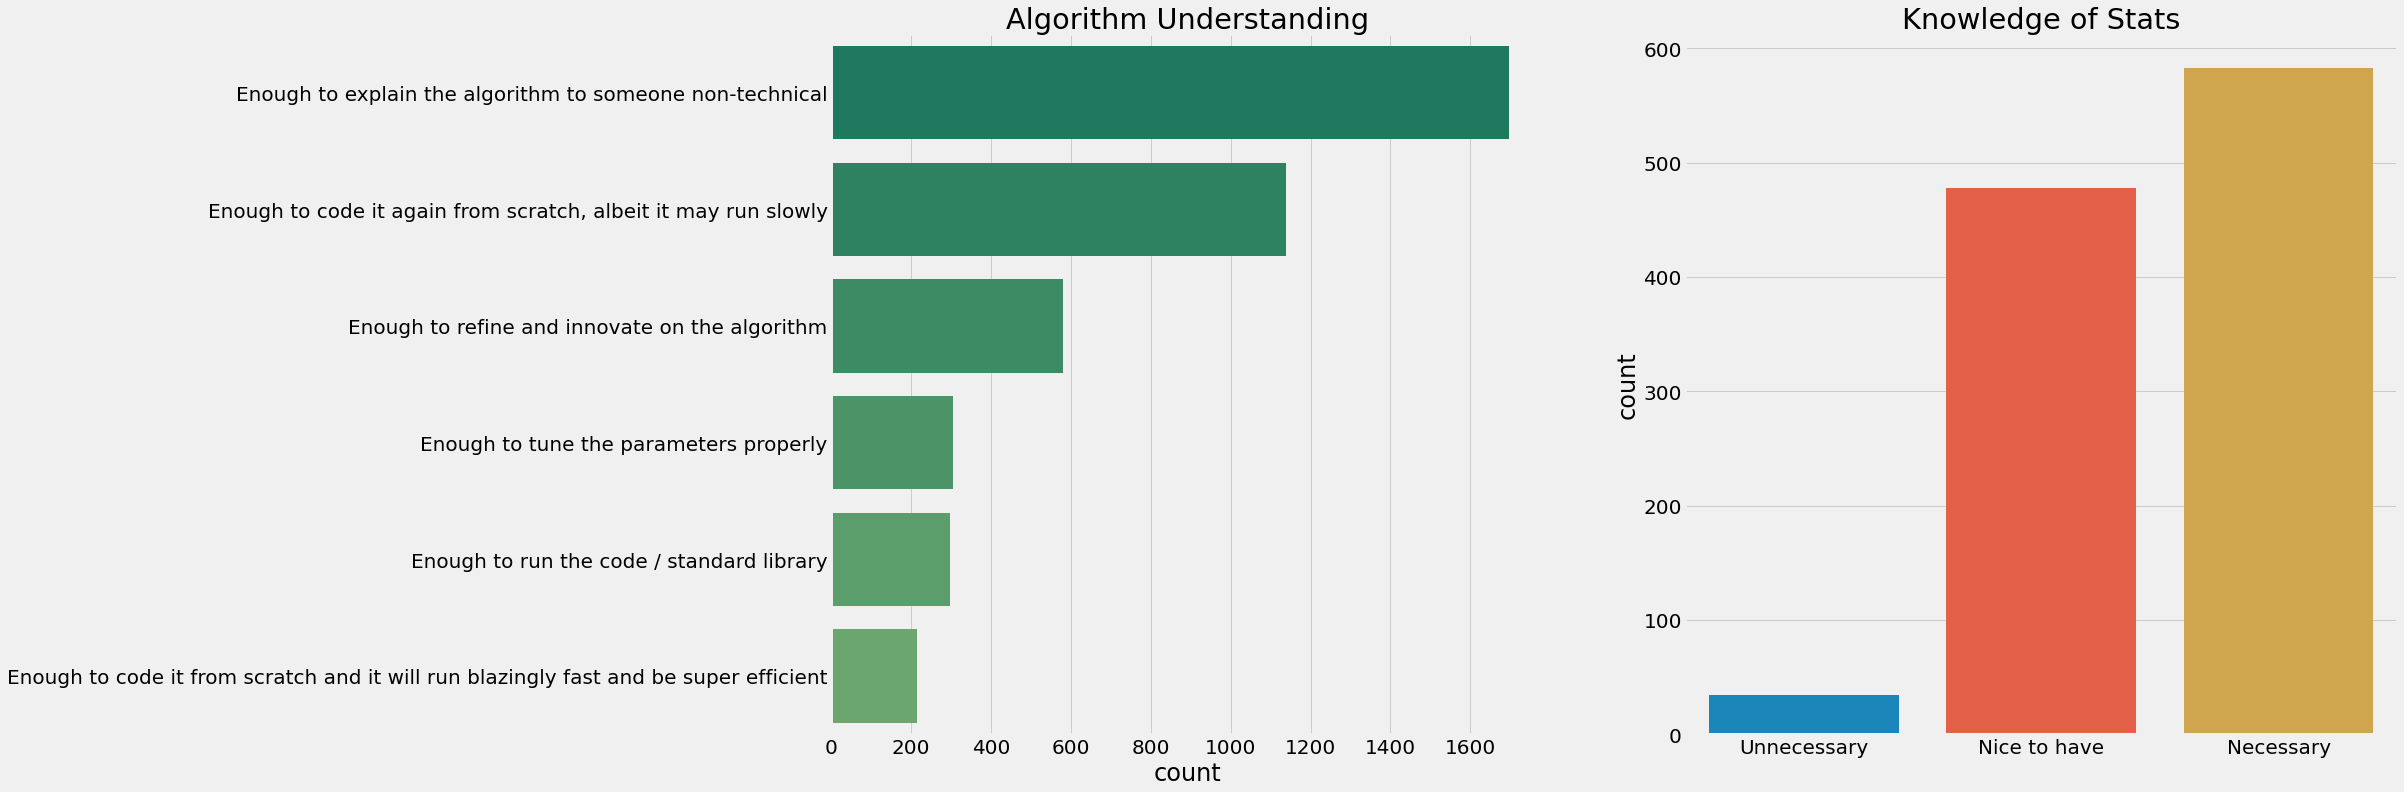

In [89]:
f,ax = plt.subplots(1,2,figsize=(25,12))
sns.countplot(y=scientist['AlgorithmUnderstandingLevel'],order=scientist['AlgorithmUnderstandingLevel'].value_counts().index,ax=ax[0],palette=sns.color_palette('summer',15))
sns.countplot(scientist['JobSkillImportanceStats'],ax=ax[1])
ax[0].set_title('Algorithm Understanding')
ax[0].set_ylabel('')
ax[1].set_title('Knowledge of Stats')
ax[1].set_xlabel('')
plt.show()

- 데이터 사이언티스트는 기계 학습 알고리즘의 통계학이나 수학적 개념에 대한 지식을 가지고 있음

## Learning Platform Usefullness

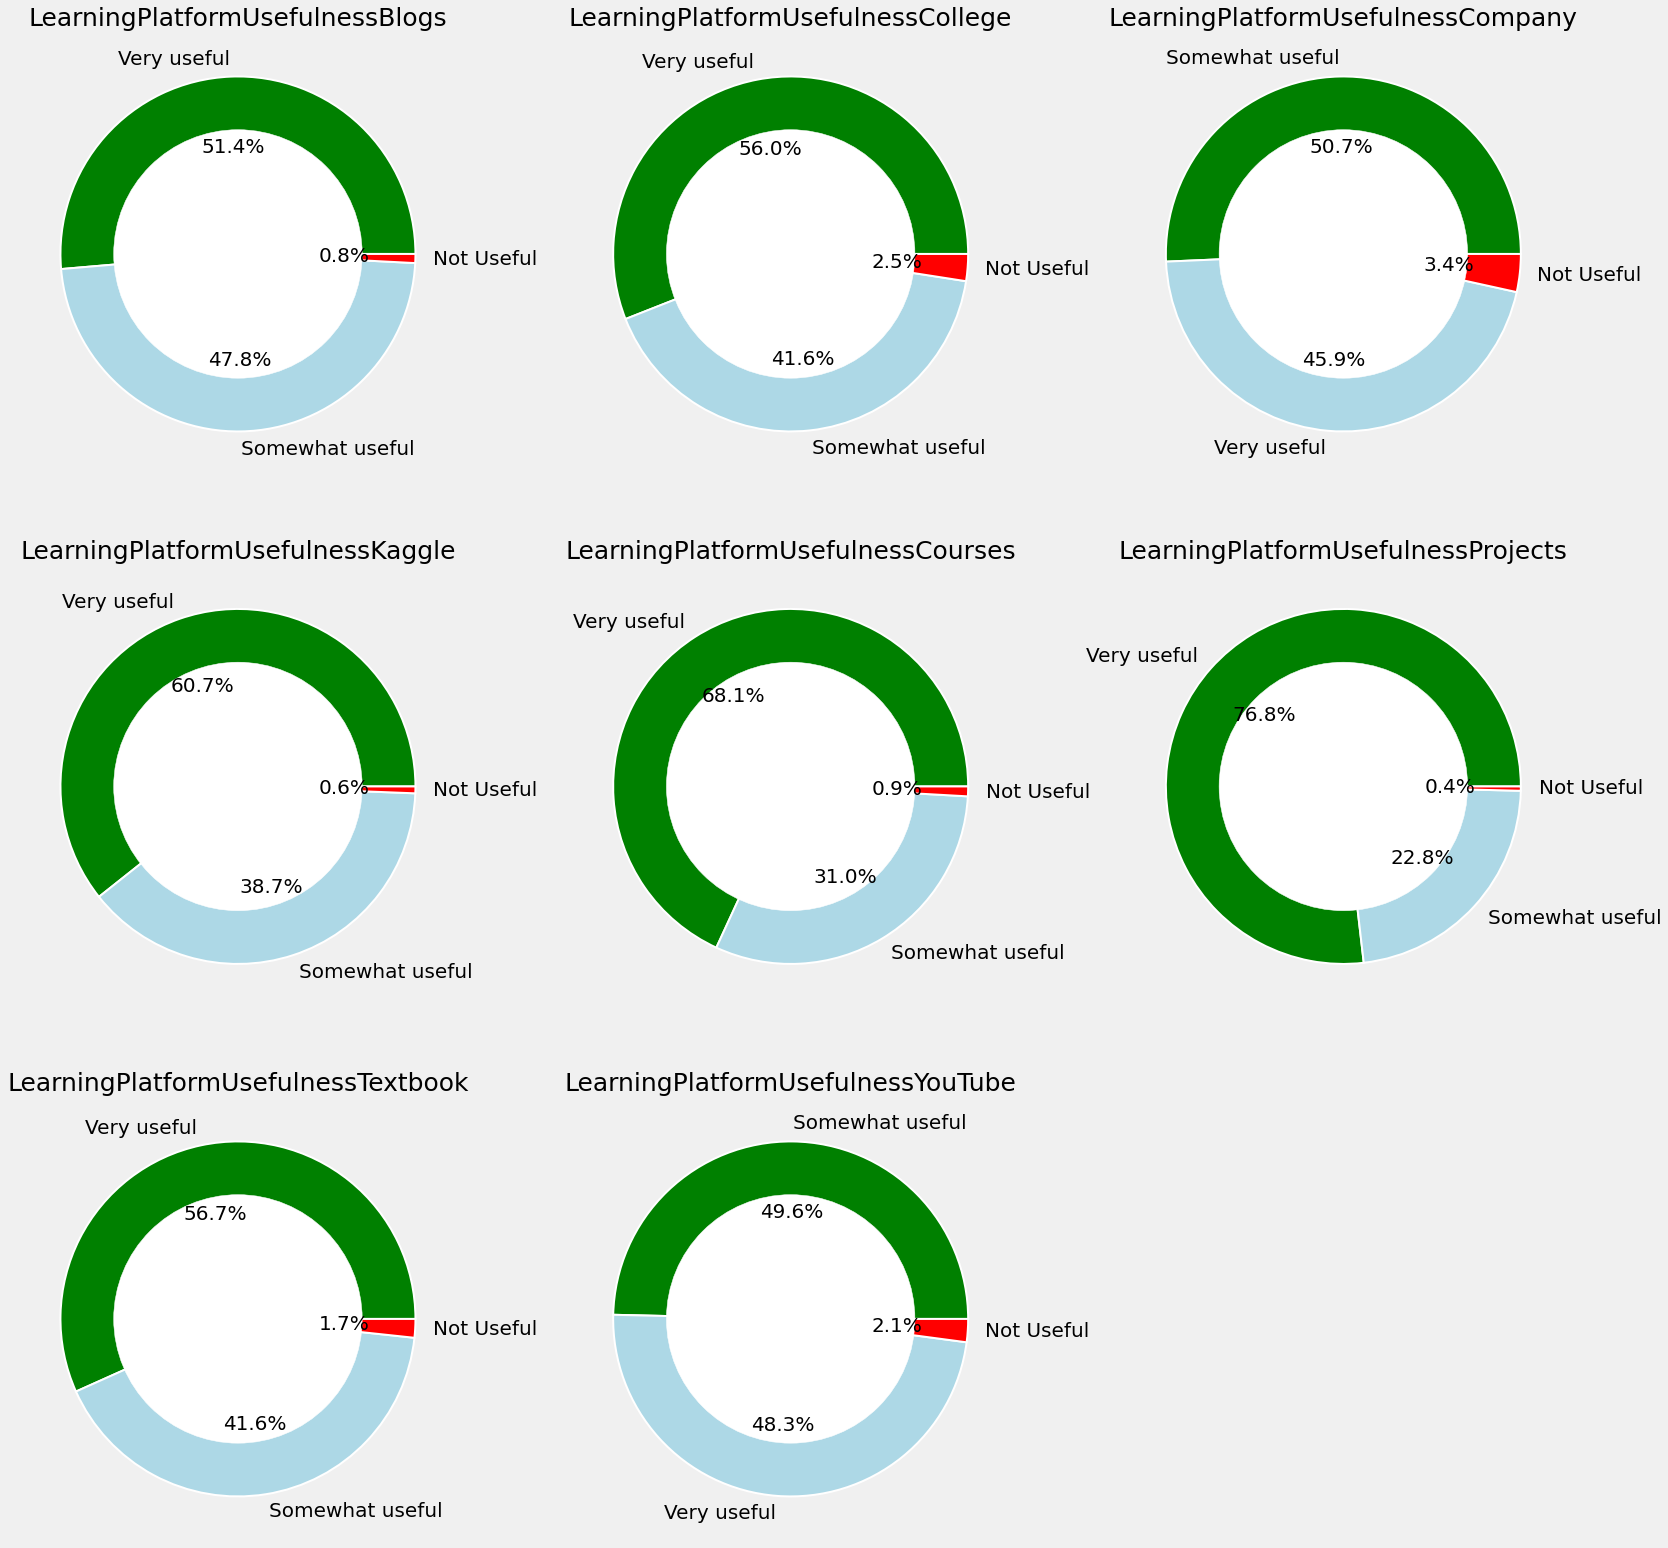

In [91]:
plt.subplots(figsize=(25,35))
useful = ['LearningPlatformUsefulnessBlogs','LearningPlatformUsefulnessCollege','LearningPlatformUsefulnessCompany','LearningPlatformUsefulnessKaggle','LearningPlatformUsefulnessCourses','LearningPlatformUsefulnessProjects','LearningPlatformUsefulnessTextbook','LearningPlatformUsefulnessYouTube']
length = len(useful)
for i,j in itertools.zip_longest(useful,range(length)):
    plt.subplot((length/2),3,j+1)
    plt.subplots_adjust(wspace=0.2,hspace=0.2)
    scientist[i].value_counts().plot.pie(autopct='%1.1f%%',colors=['g','lightblue','r'],wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' })
    plt.title(i,size=25)
    my_circle=plt.Circle( (0,0), 0.7, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.xlabel('')
    plt.ylabel('')
plt.show()


- 프로젝트는 IT 업계에서 배울 수 있는 가장 좋은 플랫폼이고, 다음은 캐글 순
- 다른 플랫폼의 그래프는 유사함

## What should the Resume have?

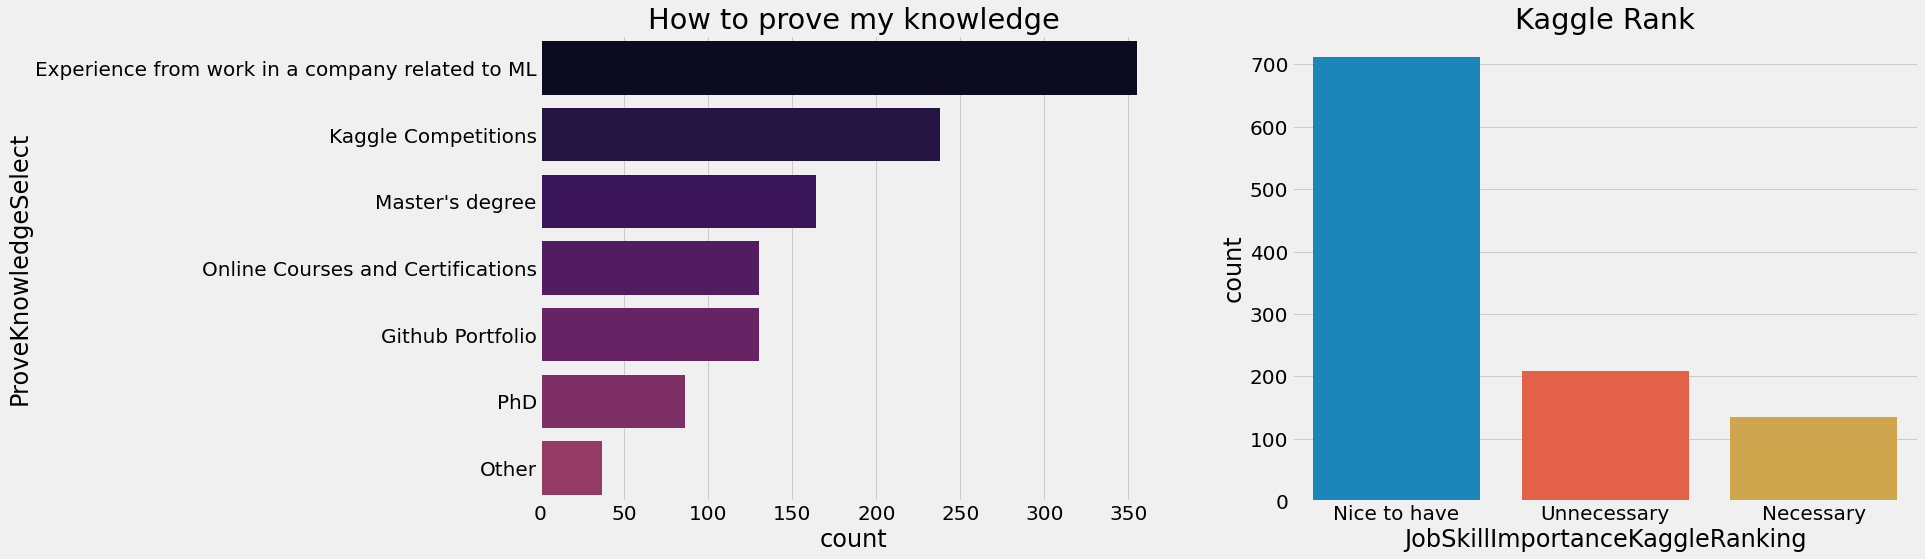

In [92]:
f,ax = plt.subplots(1,2,figsize=(22,8))
sns.countplot(y=scientist['ProveKnowledgeSelect'],order=scientist['ProveKnowledgeSelect'].value_counts().index,ax=ax[0],palette=sns.color_palette('inferno',15))
ax[0].set_title('How to prove my knowledge')
sns.countplot(scientist['JobSkillImportanceKaggleRanking'],ax=ax[1])
ax[1].set_title('Kaggle Rank')
plt.show()

- ML 프로젝트 및 Kaggle 대회 경험이 데이터 사이언스에 대한 지식을 반영하고, 석사나 박사 학위보다 더 높은 가치

## How did they search for Jobs??

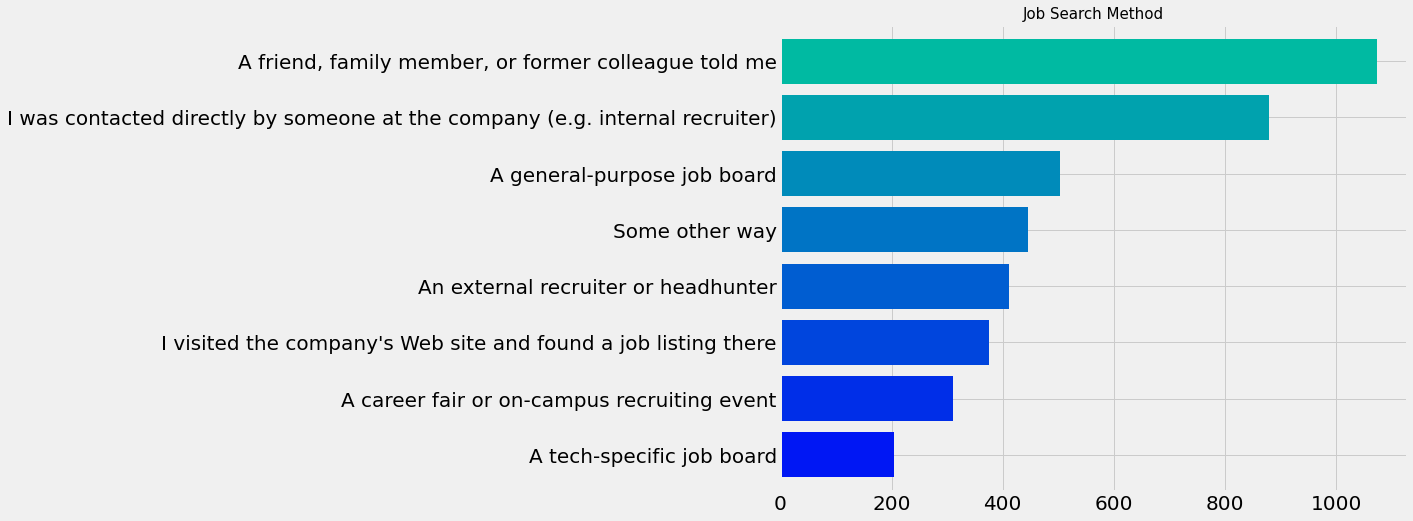

In [93]:
plt.subplots(figsize=(10,8))
scientist.groupby(['EmployerSearchMethod'])['Age'].count().sort_values(ascending=True).plot.barh(width=0.8,color=sns.color_palette('winter',10))
plt.title('Job Search Method',size=15)
plt.ylabel('')
plt.show()

- 다수의 데이터 사이언티스트는 친구나, 가족 등 지인으로부터 직장을 얻음
- 그러므로 링크드인과 같은 곳에 이력을 지속적으로 업데이트 하는 것이 꿈의 직장을 얻는 것에 도움을 줄 것

## Checking the Free Resopnses

In [96]:
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
free = pd.read_csv('freeformResponses.csv')
stop_words = set(stopwords.words('english'))
stop_words.update(',',';','!','?','.','(',')','$','#','+',':','...')

## Motivation Behind Working on Kaggle

In [99]:
nltk.download('punkt')
motivation = free['KaggleMotivationFreeForm'].dropna().apply(nltk.word_tokenize)
motivate = []
for i in motivation:
    motivate.extend(i)
motivate = pd.Series(motivate)
motivate = ([i for i in motivate.str.lower() if i not in stop_words])
f1 = open('kaggle.png', 'wb')
f1.write(codecs.decode(kaggle, 'base64'))
f1.close()
img1 = imread('kaggle.png')
wc = WordCloud(background_color='black', max_words=4000, mask=hcmask1, stopwords=STOPWORDS, max_font_size=60, width=1000, height=1000)
wc.generate(" ".join(motivate))
plt.imshow(wc)
plt.axis('off')
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


NameError: ignored

## Most Frequently Used Libraries

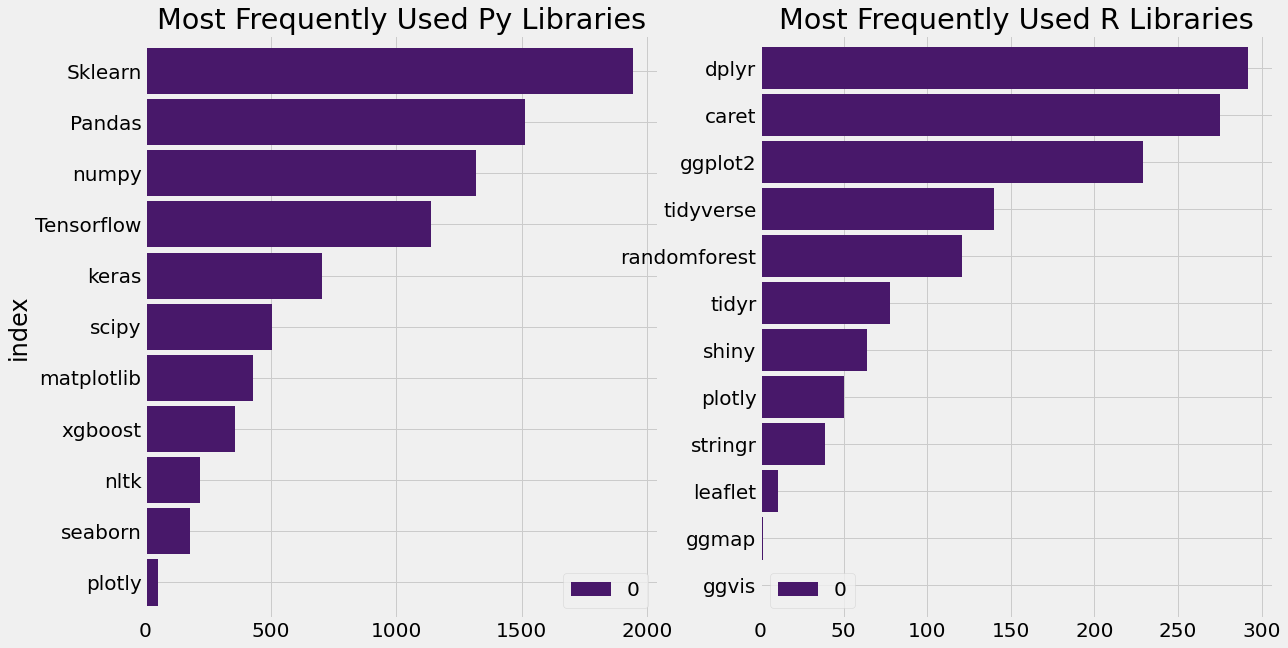

In [101]:
library = free['WorkLibrariesFreeForm'].dropna().apply(nltk.word_tokenize)
lib = []
for i in library:
  lib.extend(i)
lib = pd.Series(lib)
lib = ([i for i in lib.str.lower() if i not in stop_words])
lib = pd.Series(lib)
lib = lib.value_counts().reset_index()
lib.loc[lib['index'].str.contains('Pandas|pandas|panda'),'index']='Pandas'
lib.loc[lib['index'].str.contains('Tensorflow|tensorflow|tf|tensor'),'index']='Tensorflow'
lib.loc[lib['index'].str.contains('Scikit|scikit|sklearn'),'index']='Sklearn'
lib = lib.groupby('index')[0].sum().sort_values(ascending=False).to_frame()
R_packages = ['dplyr','tidyr','ggplot2','caret','randomforest','shiny','R markdown','ggmap','leaflet','ggvis','stringr','tidyverse','plotly']
Py_packages = ['Pandas','Tensorflow','Sklearn','matplotlib','numpy','scipy','seaborn','keras','xgboost','nltk','plotly']
f,ax = plt.subplots(1,2,figsize=(18,10))
lib[lib.index.isin(Py_packages)].sort_values(by=0, ascending=True).plot.barh(ax=ax[0],width=0.9,color=sns.color_palette('viridis',15))
ax[0].set_title('Most Frequently Used Py Libraries')
lib[lib.index.isin(R_packages)].sort_values(by=0,ascending=True).plot.barh(ax=ax[1],width=0.9,color=sns.color_palette('viridis',15))
ax[1].set_title('Most Frequently Used R Libraries')
ax[1].set_ylabel('')
plt.show()

# Conclusions

1. 응답자의 대부분은 미국인과 인도인이며, 급여 중앙값이 가장 높은 나라는 미국
2. 응답자의 대부분은 20-35세이며, 나이가 어린 사람들에게 꽤 인기있음을 보여줌
3. 응답자의 전공은 컴퓨터 사이언스에만 국한되지 않고, 통계, 헬스 사이언스 등 여러 도메인이 융합됨
4. 대부분의 응답자들은 풀타임으로 근무 중
5. 캐글, 온라인 코스, 프로젝트와 블로그가 데이터 사이언스를 배우는 최고의 플랫폼
6. 데이터 수집 점유율은 케글이 높고, 코드 공유 점유율은 깃헙이 높음
7. 데이터 사이언티스트들은 가장 높은 직업 만족도를 보이며, 두번째로 높은 급여 중앙값을 나타냄. 반면 프로그래머들은 가장 낮은 직업만족도와 급여 중앙값을 나타냄
8. 데이터 사이언티스트는 직업 전환으로 6-20%의 급여 인상이 있었음

## 새로운 데이터 과학자를 위한 팁
1. Python, R, SQL을 배워라
2. 머신러닝에서 Logistic Regression, Decision Trees, Support Vector Machines 등을 익혀라
3. 딥러닝과 신경망은 미래에 유망한 기술이니 알아두면 좋다.
4. 데이터 수집과 전처리에 가장 많은 시간이 소요됨
5. 데이터 시각화는 프로젝트에서 데이터를 더 이해하기 쉽게 도와주는 매우 중요한 기술 중 하나이다.
6. 알고리즘을 이해하려면 수학과 통계 또한 매우 중요
7. 프로젝트가 데이터 사이언스를 익히는데 가장 좋은 방법
8. ML 프로젝트와 캐글 대회 경험이 데이터 사이언스에 대한 이해를 보여주는 가장 좋은 지표
